# Analysis of 3k T cells from cancer

In [1]:
# This cell is for development only. Don't copy this to your notebook.
%load_ext autoreload
%autoreload 2

# Temporarily suppress FutureWarnings
import warnings
from numba import NumbaDeprecationWarning

warnings.simplefilter(action="ignore", category=(FutureWarning, NumbaDeprecationWarning))

In [2]:
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

# temporary fix for deprecated matplotlib functionality
import IPython.display
from matplotlib_inline.backend_inline import set_matplotlib_formats

IPython.display.set_matplotlib_formats = set_matplotlib_formats

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.logging.print_header()

/tmp/ipykernel_9236/1023403583.py:1: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


numba	0.62.1
cycler	0.12.1
matplotlib-inline	0.1.7
----	----
texttable	1.7.0
zipp	3.23.0
PyYAML	6.0.3
llvmlite	0.45.1
charset-normalizer	3.4.4
statsmodels	0.14.5
pynndescent	0.5.13
parso	0.8.5
pytz	2025.2
six	1.17.0
jedi	0.19.2
networkx	3.4.2
python-dateutil	2.9.0.post0
pure_eval	0.2.3
executing	2.2.1
ipython	8.37.0
kiwisolver	1.4.9
h5py	3.15.0
pooch	1.8.2 (v1.8.2)
asttokens	3.0.0
igraph	0.11.9
stack-data	0.6.3
pillow	11.3.0
wcwidth	0.2.14
setuptools	80.9.0
decorator	5.2.1
prompt_toolkit	3.0.52
importlib_metadata	8.7.0
debugpy	1.8.17
joblib	1.5.2
natsort	8.4.0
tqdm	4.67.1
umap-learn	0.5.9.post2
adjustText	1.3.0
tornado	6.5.2
psutil	7.1.0
patsy	1.0.1
----	----
Python	3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]
OS	Linux-4.18.0-305.12.1.el8_4.x86_64-x86_64-with-glibc2.31
CPU	288 logical CPU cores, x86_64
GPU	ID: 0, Tesla P100-PCIE-16GB, Driver: 470.57.02, Memory: 16280 MiB
GPU	ID: 1, Tesla P100-PCIE-16GB, Driver: 470.57.02, Memory: 16280 MiB
GPU	ID: 2, Tesla P100-PCIE-16GB, Driver: 470.57.02, Memory: 16280 MiB
GPU	ID: 3, Tesla P100-PCIE-16GB, Driver: 470.57.02, Memory: 16280 MiB
Updated	2025-10-14 20:14

In this tutorial, we re-analyze single-cell TCR/RNA-seq data from Wu et al. {cite}`Wu2020`.
generated on the 10x Genomics platform. The original dataset consists of >140k T cells
from 14 treatment-naive patients across four different types of cancer.
For this tutorial, to speed up computations, we use a downsampled version of 3k cells.

## Importing data

`Scirpy` natively supports reading {term}`IR` data from [Cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) (10x), 
[TraCeR](https://github.com/Teichlab/tracer) (Smart-seq2)
or the [AIRR rearrangement schema](https://docs.airr-community.org/en/latest/datarep/rearrangements.html) and provides helper functions to import other data types. We provide a {ref}`dedicated tutorial on data loading <importing-data>` with more details.

:::{warning}
**scirpy's data structure has been updated in v0.13.0.**

Previously, receptor data was expanded into columns of `adata.obs`, now they are stored as an {term}`awkward array` in `adata.obsm["airr"]`. 
Moreover, we now use {class}`~mudata.MuData` to handle paired transcriptomics and {term}`AIRR` data. 

`AnnData` objects created with older versions of scirpy can be upgraded with {func}`scirpy.io.upgrade_schema` to be compatible with the latest version of scirpy.

Please check out

 * The {ref}`release notes <v0.13>` for details about the changes
 * The documentation about {ref}`Scirpy's data structure <data-structure>` and
 * {ref}`Scirpy's receptor model <receptor-model>`. 
:::


The example dataset for this tutorial ships with the `scirpy` package. We can conveniently load it from the {mod}`~scirpy.datasets` module: 

In [4]:
mdata = ir.datasets.wu2020_3k()

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


`mdata` is a {class}`~mudata.MuData` object with two modalities: `gex` for gene expression and `airr` for immune-receptor data. 

In [5]:
mdata

MuData object with n_obs × n_vars = 3000 × 30727
  2 modalities
    gex:	3000 x 30727
      obs:	'cluster_orig', 'patient', 'sample', 'source'
      uns:	'cluster_orig_colors'
      obsm:	'X_umap_orig'
    airr:	3000 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig'
      obsm:	'airr'

## Preprocessing Transcriptomics data

Gene expression (GEX) data needs to be filtered and preprocessed as with any other single-cell dataset.
For this tutorial, we perform minimal preprocessing for demonstration purposes. For a real dataset, we recommend following the [scverse tutorials](https://scverse.org/learn/)
and the [single-cell best practice book](https://sc-best-practices.org/).

In [6]:
sc.pp.filter_genes(mdata["gex"], min_cells=10)
sc.pp.filter_cells(mdata["gex"], min_genes=100)

filtered out 18877 genes that are detected in less than 10 cells


In [7]:
sc.pp.normalize_per_cell(mdata["gex"])
sc.pp.log1p(mdata["gex"])
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(mdata["gex"])
sc.pp.neighbors(mdata["gex"])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04)


For the _Wu2020_ dataset, the authors already provide clusters and UMAP coordinates.
Instead of performing clustering and cluster annotation ourselves, we will just use
the provided data. The clustering and annotation methodology is
described in [their paper](https://doi.org/10.1038/s41586-020-2056-8).

In [8]:
mdata["gex"].obsm["X_umap"] = mdata["gex"].obsm["X_umap_orig"]

In [9]:
mapping = {
    "nan": "other",
    "3.1-MT": "other",
    "4.1-Trm": "CD4_Trm",
    "4.2-RPL32": "CD4_RPL32",
    "4.3-TCF7": "CD4_TCF7",
    "4.4-FOS": "CD4_FOSS",
    "4.5-IL6ST": "CD4_IL6ST",
    "4.6a-Treg": "CD4_Treg",
    "4.6b-Treg": "CD4_Treg",
    "8.1-Teff": "CD8_Teff",
    "8.2-Tem": "CD8_Tem",
    "8.3a-Trm": "CD8_Trm",
    "8.3b-Trm": "CD8_Trm",
    "8.3c-Trm": "CD8_Trm",
    "8.4-Chrom": "other",
    "8.5-Mitosis": "other",
    "8.6-KLRB1": "other",
}
mdata["gex"].obs["cluster"] = mdata["gex"].obs["cluster_orig"].map(mapping)

Now that we filtered obs and var of the GEX modality, we need to propagate those changes back to the `MuData` object.

In [10]:
mdata.update()

Let's inspect the UMAP plots. The first three panels show the UMAP plot colored by sample, patient and cluster.
We don't observe any obvious clustering of samples or patients that could hint at batch effects.

The last three panels show the UMAP colored by the T cell markers _CD8_, _CD4_, and _FOXP3_.
We can confirm that the markers correspond to their respective cluster labels.

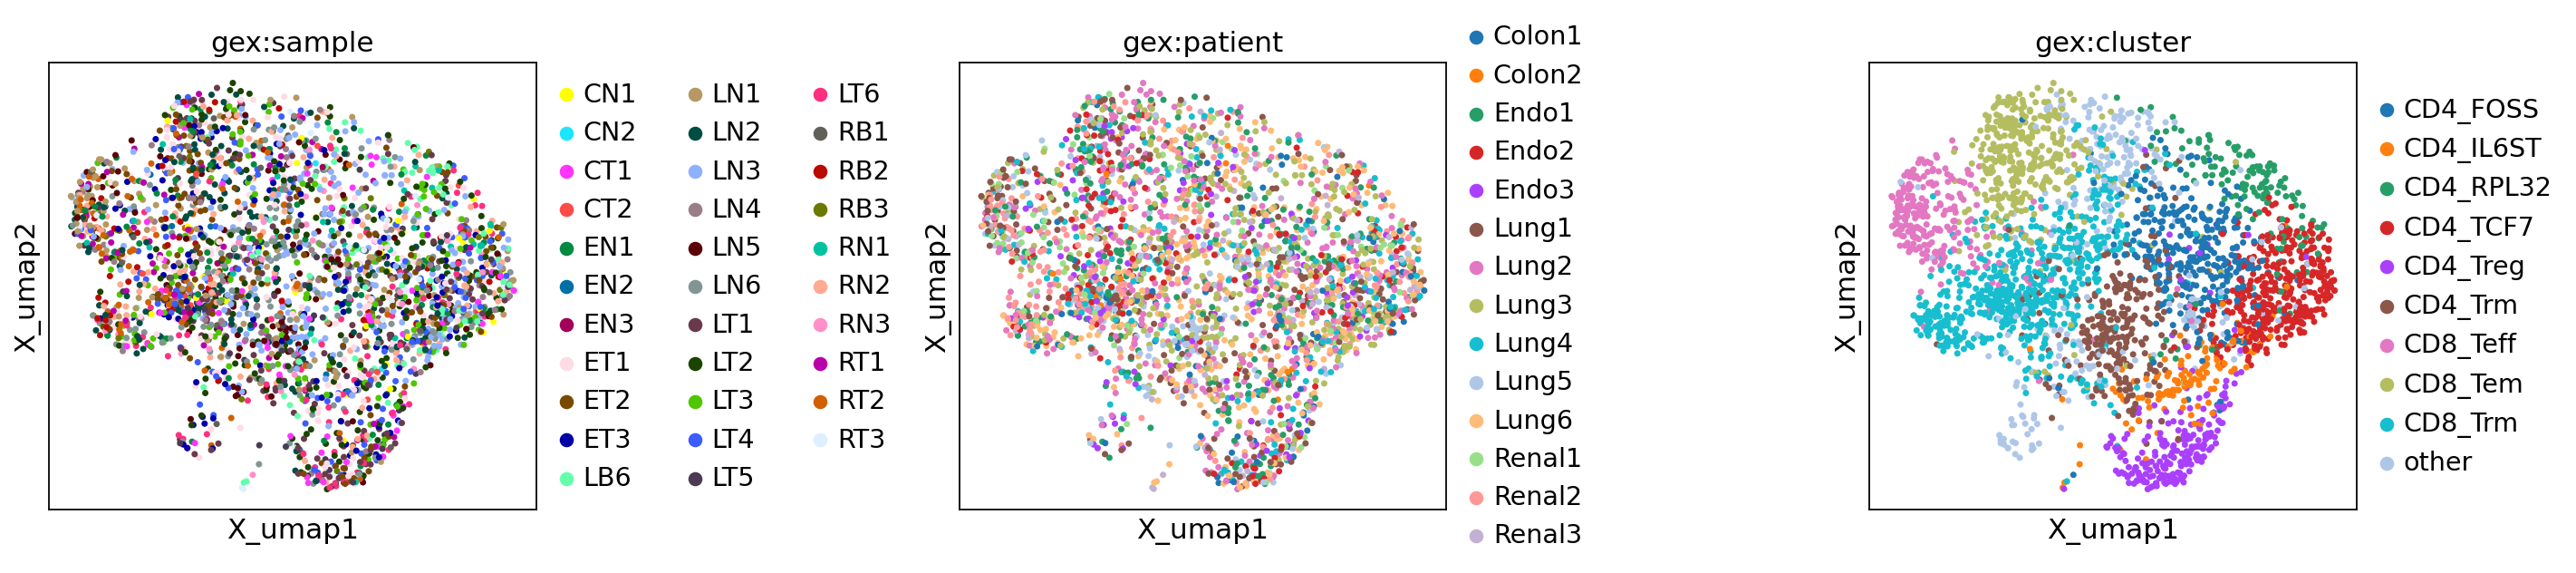

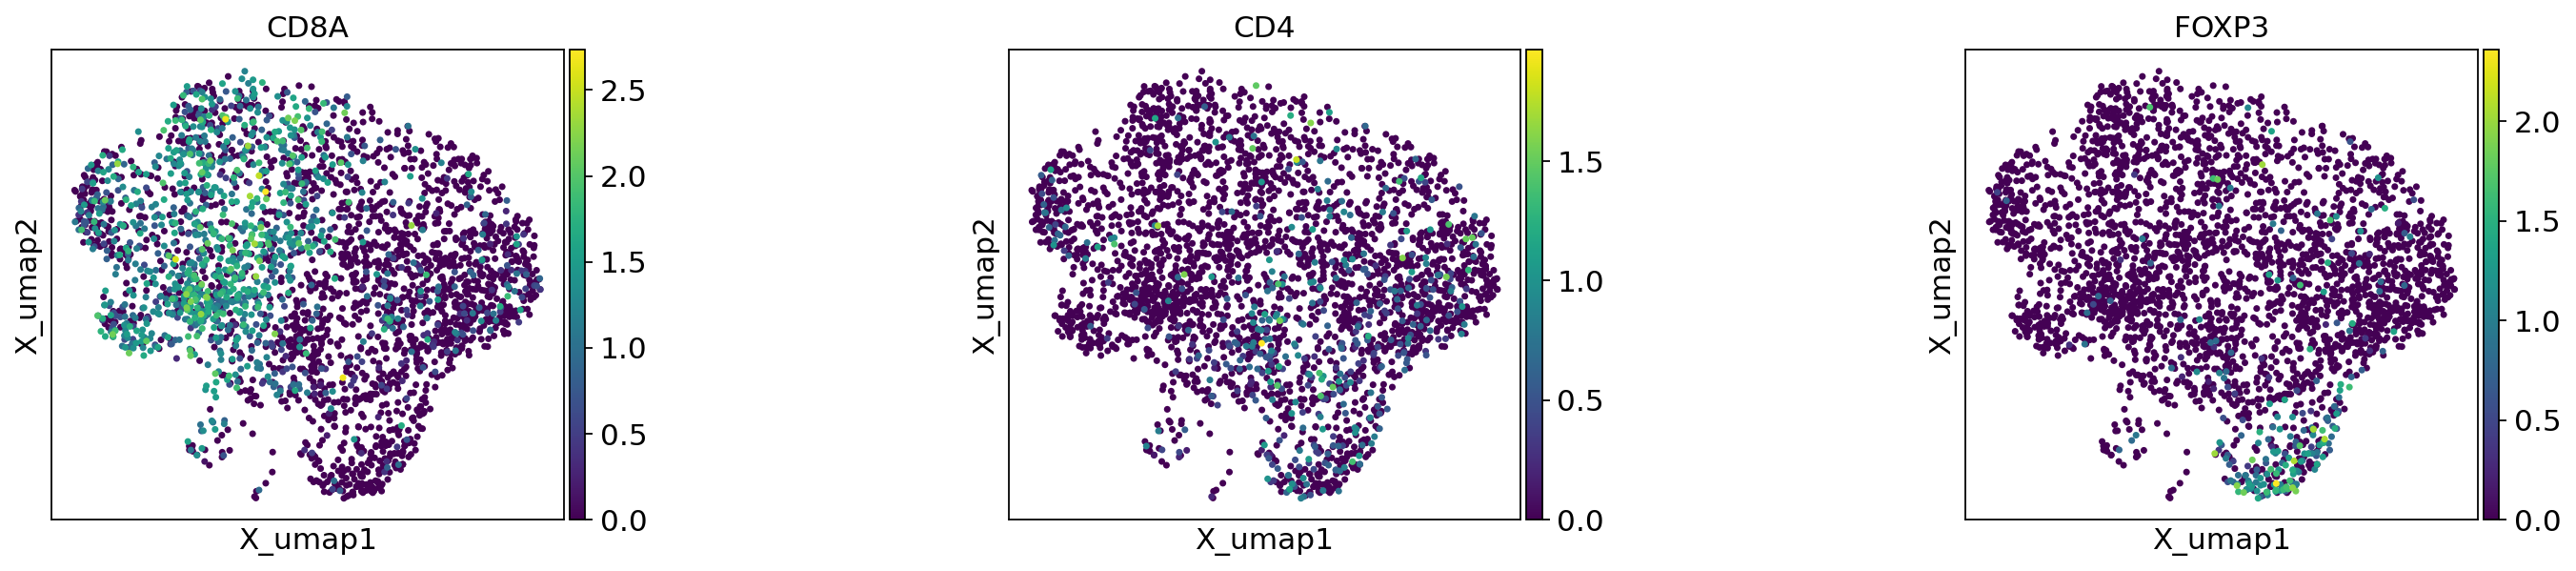

In [11]:
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["gex:sample", "gex:patient", "gex:cluster"],
    ncols=3,
    wspace=0.7,
)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["CD8A", "CD4", "FOXP3"],
    ncols=3,
    wspace=0.7,
)

## Creating chain indices

As a first step, we need to create {ref}`chain indices <chain-indices>` for the receptor data. 

By importing {term}`IR` data, essentially, for each cell a list of receptor chains is stored in `adata.obsm["airr"]`. 
The {ref}`scirpy receptor model <receptor-model>` allows up to two pairs of chains per cell. This representation 
requires separation of chains by {term}`locus <Chain locus>` into {term}`VJ <V(D)J>` and {term}`VDJ <V(D)J>` chains, 
and (optionally) filtering non-productive chains. 

The {func}`~scirpy.pp.index_chains` function applies the scirpy receptor model by storing references to the 
selected chains in `adata.obsm["chain_indices"]`. 

In [12]:
ir.pp.index_chains(mdata)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


## TCR Quality Control


While most of T cell receptors have exactly one pair of α and β chains, up to one third of
T cells can have {term}`dual TCRs<Dual IR>`, i.e. two pairs of receptors originating from different alleles ({cite}`Schuldt2019`).

Using the {func}`scirpy.tl.chain_qc` function, we can add a summary
about the Immune cell-receptor compositions to `adata.obs`. We can visualize it using {func}`scirpy.pl.group_abundance`.

:::{note}
**chain pairing**

- *Orphan chain* refers to cells that have either a single alpha or beta receptor chain.
- *Extra chain* refers to cells that have a full alpha/beta receptor pair, and an additional chain.
- {term}`Multichain <Multichain-cell>` refers to cells with more than two receptor pairs detected.
  These cells are likely doublets.

**receptor type and receptor subtype**

- `receptor_type` refers to a coarse classification into `BCR` and `TCR`. Cells with both `BCR` and `TCR` chains
  are labelled as `ambiguous`.
- `receptor_subtype` refers to a more specific classification into α/β, ɣ/δ, IG-λ, and IG-κ chain configurations.

For more details, see {func}`scirpy.tl.chain_qc`.
:::

In [13]:
ir.tl.chain_qc(mdata)

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


As expected, the dataset contains only α/β T-cell receptors:

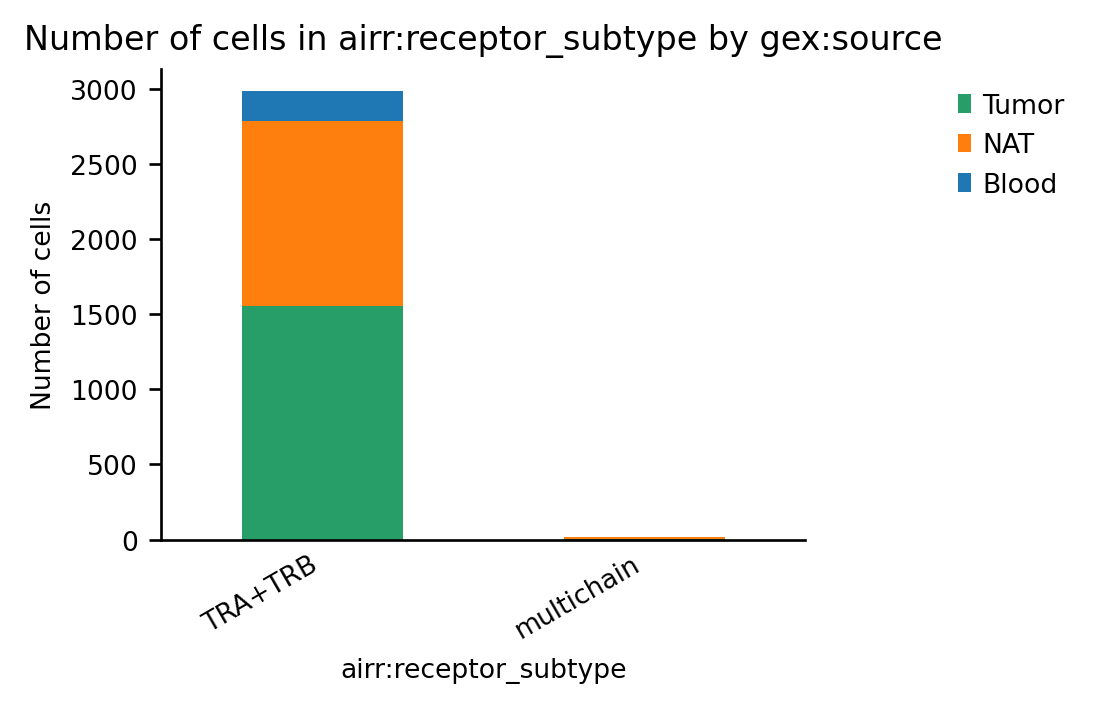

In [14]:
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="gex:source")

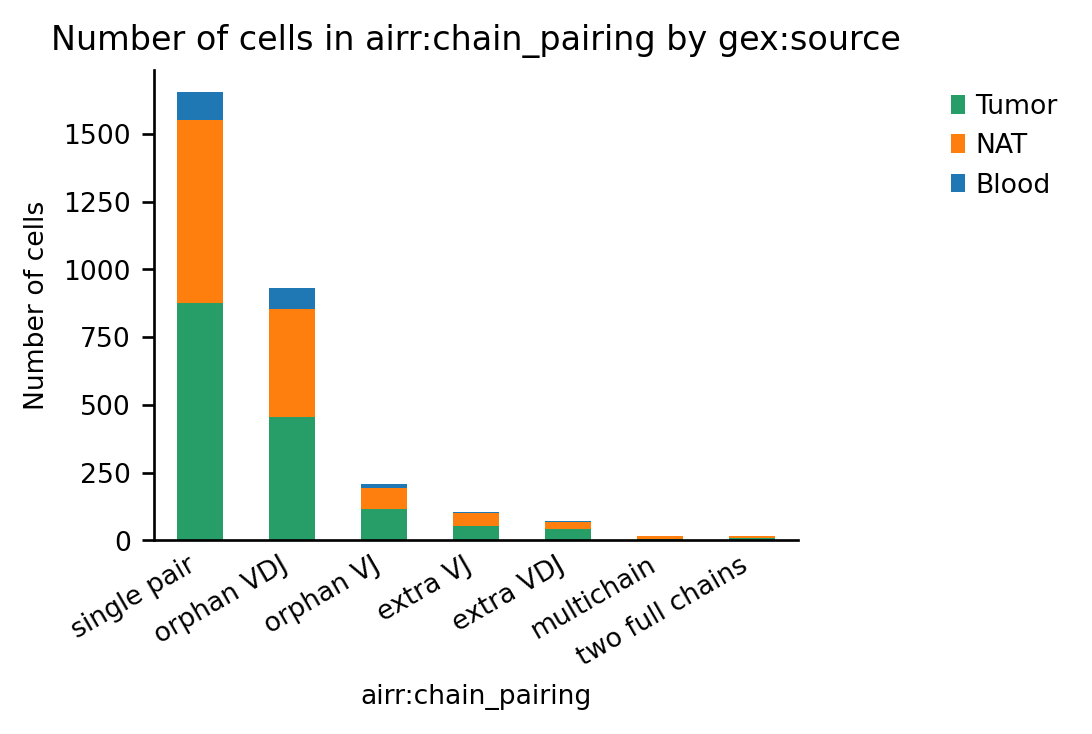

In [15]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:source")

Indeed, in this dataset, ~7% of cells have more than
one pair of productive T-cell receptors:

In [16]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.07



Next, we visualize the {term}`Multichain-cells <Multichain-cell>` on the UMAP plot and exclude them from downstream analysis:


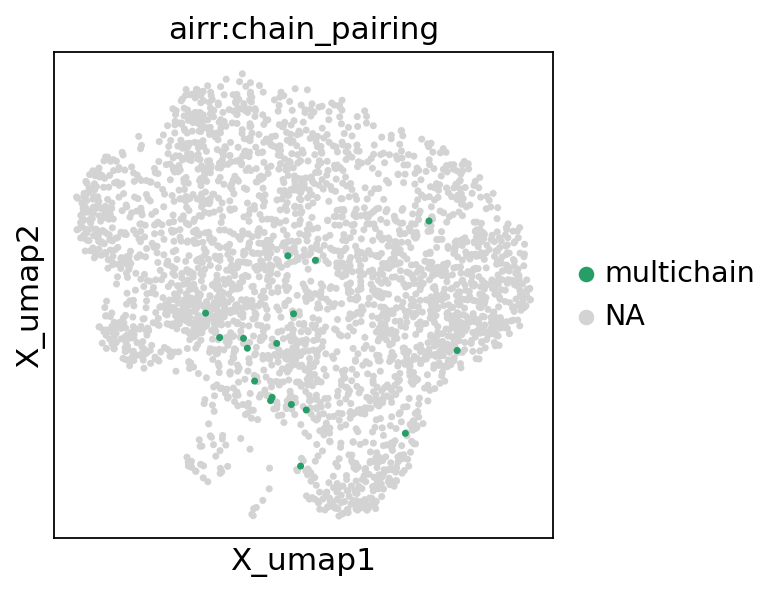

In [17]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:chain_pairing", groups="multichain")

In [18]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x != "multichain")

Similarly, we can use the `chain_pairing` information to exclude all cells that don't have at least
one full pair of receptor sequences:

In [19]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))

In [20]:
mdata

MuData object with n_obs × n_vars = 1845 × 11850
  2 modalities
    gex:	1845 x 11850
      obs:	'cluster_orig', 'patient', 'sample', 'source', 'n_genes', 'n_counts', 'cluster'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cluster_orig_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'gex:sample_colors', 'gex:patient_colors', 'gex:cluster_colors', 'airr:chain_pairing_colors'
      obsm:	'X_umap_orig', 'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	1845 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig', 'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

Finally, we re-create the chain-pairing plot to ensure that the filtering worked
as expected:

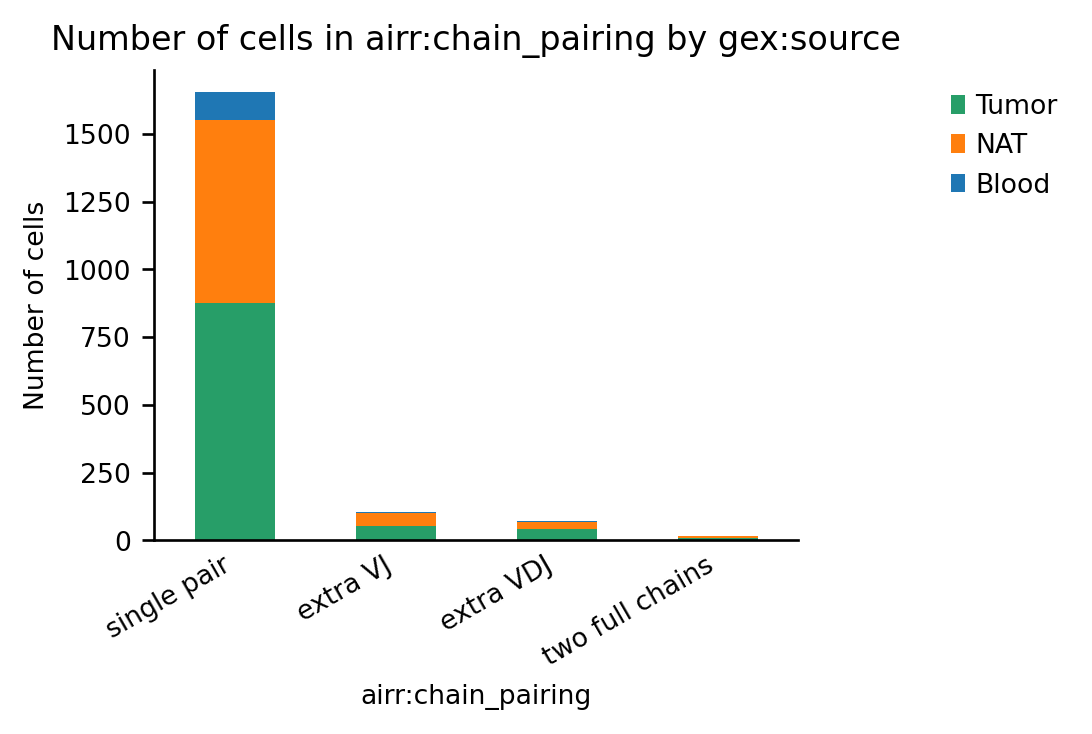

In [21]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:source")

## Define clonotypes and clonotype clusters

(define-clonotypes-tutorial)=

In this section, we will define and visualize {term}`clonotypes <Clonotype>` and {term}`clonotype clusters <Clonotype cluster>`.

*Scirpy* implements a network-based approach for clonotype definition. The steps to create and visualize the clonotype-network are analogous to the construction of a neighborhood graph from transcriptomics data with *Scanpy*.

```{eval-rst}
.. list-table:: Analysis steps on IR data
    :widths: 40 60
    :header-rows: 1

    - - scirpy function
      - objective
    - - :func:`scirpy.pp.ir_dist`
      - Compute sequence-based distance matrices for all :term:`VJ <Chain locus>` and
        :term:`VDJ <Chain locus>` sequences.
    - - :func:`scirpy.tl.define_clonotypes`
      - Define :term:`clonotypes <Clonotype>` by nucleotide
        sequence identity.
    - - :func:`scirpy.tl.define_clonotype_clusters`
      - Cluster cells by the similarity of their CDR3-sequences.
    - - :func:`scirpy.tl.clonotype_network`
      - Compute layout of the clonotype network.
    - - :func:`scirpy.pl.clonotype_network`
      - Plot clonotype network colored by different parameters.
```


### Compute CDR3 neighborhood graph and define clonotypes


{func}`scirpy.pp.ir_dist` computes distances between {term}`CDR3 <CDR>` nucleotide (`nt`) or amino acid (`aa`) sequences, either based on sequence identity or similarity. It creates two distance matrices: one for all unique {term}`VJ <Chain locus>` sequences and one for all unique {term}`VDJ <Chain locus>` sequences. The distance matrices are added to `adata.uns`.

The function {func}`scirpy.tl.define_clonotypes` matches cells based on the distances of their
`VJ` and `VDJ` CDR3-sequences and value of the function parameters `dual_ir` and `receptor_arms`. Finally, it
detects connected modules in the graph and annotates them as clonotypes. This will add a `clone_id` and
`clone_id_size` column to `adata.obs`.

The `dual_ir` parameter defines how scirpy handles cells with {term}`more than one pair of receptors <Dual IR>`. The default value is `any` which implies that cells with any of their primary or secondary receptor chain matching will be considered to be of the same clonotype.

Here, we define {term}`clonotypes <Clonotype>` based on nt-sequence identity.
In a later step, we will define {term}`clonotype clusters <Clonotype cluster>` based on
amino-acid similarity.


In [22]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.



To visualize the network we first call {func}`scirpy.tl.clonotype_network` to compute the layout.
We can then visualize it using {func}`scirpy.pl.clonotype_network`. We recommend setting the
`min_cells` parameter to `>=2`, to prevent the singleton clonotypes from cluttering the network.


In [23]:
ir.tl.clonotype_network(mdata, min_cells=2)


The resulting plot is a network, where each dot represents cells with identical
receptor configurations. As we define {term}`clonotypes <Clonotype>` as cells with identical CDR3-sequences, each
dot is also a clonotype. For each clonotype, the numeric clonotype id is shown in the graph.
The size of each dot refers to the number of cells with the same receptor configurations.
Categorical variables can be visualized as pie charts.


In [24]:
mdata.obs.groupby("gex:source", dropna=False).size()

gex:source
Blood    107
NAT      756
Tumor    982
dtype: int64

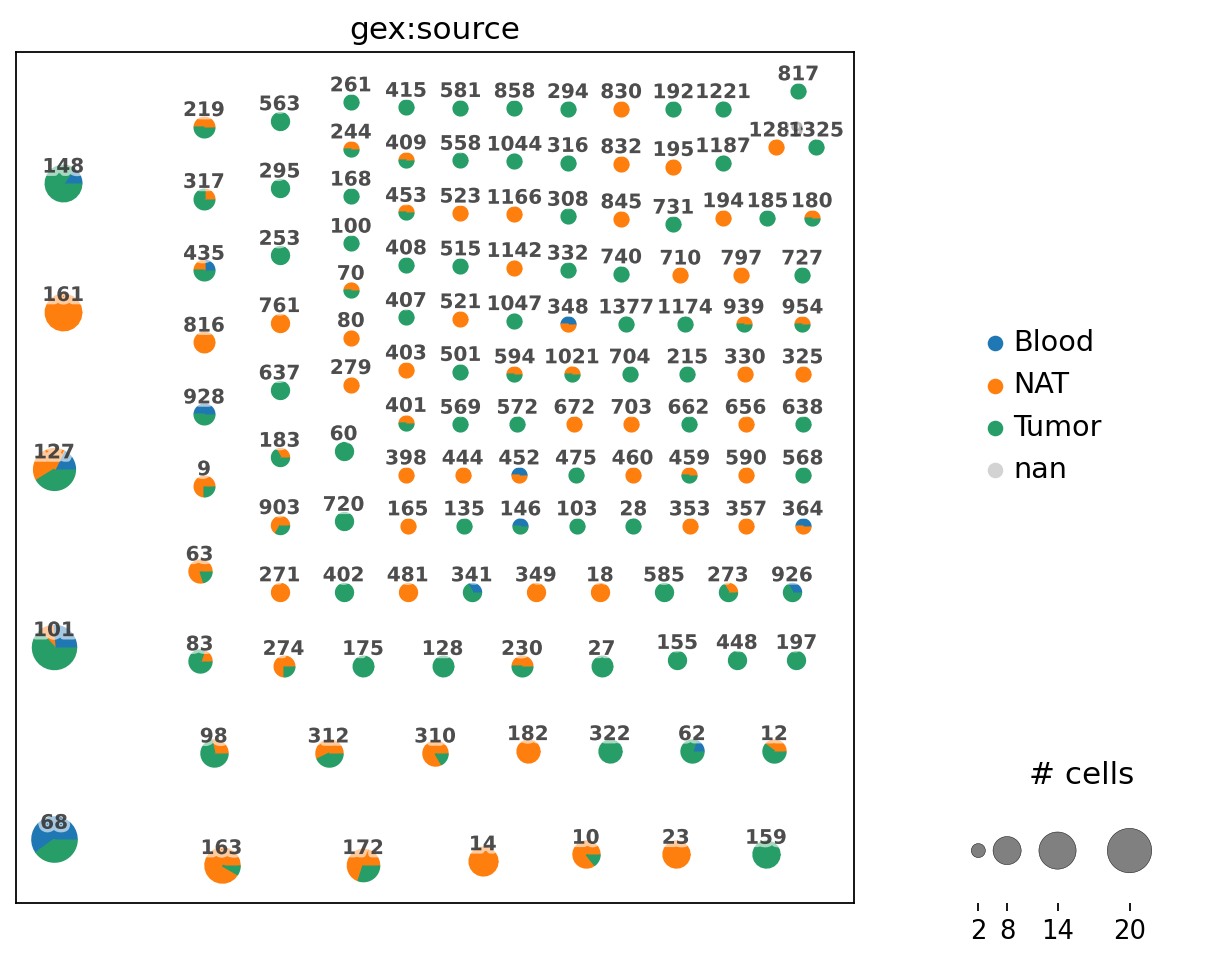

In [25]:
_ = ir.pl.clonotype_network(mdata, color="gex:source", base_size=20, label_fontsize=9, panel_size=(7, 7))

### Re-compute CDR3 neighborhood graph and define clonotype clusters


We can now re-compute the clonotype network based on amino-acid sequence similarity
and define {term}`clonotype clusters <Clonotype cluster>`.

To this end, we need to set `metric="tcrdist"` and specify a `cutoff` parameter.
The distance is based on the [BLOSUM62](https://en.wikipedia.org/wiki/BLOSUM) matrix.
For instance, a distance of `10` is equivalent to 2 Rs mutating into N.
This appoach was initially proposed by Dash et al. {cite}`TCRdist` and is based on the [tcrdist3](https://github.com/kmayerb/tcrdist3) implementation.

All cells with a distance between their CDR3 sequences lower than `cutoff` will be connected in the network.


In [26]:
ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

Computing sequence x sequence distance matrix for VJ sequences.


/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scirpy/ir_dist/metrics.py:1356: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  data_rows[row_index][0] = data_row_matrix[thread_id, 0:row_end_index].copy()


Computing sequence x sequence distance matrix for VDJ sequences.


In [27]:
ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")

Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:cc_aa_tcrdist"]`.
Stored result in `mdata.obs["airr:cc_aa_tcrdist_size"]`.


In [28]:
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="tcrdist")

Compared to the previous plot, we observere several connected dots.
Each fully connected subnetwork represents a "clonotype cluster", each dot
still represents cells with identical receptor configurations.

The dots are colored by patient. We observe, that for instance, clonotypes `101` and `68` (left top and bottom) are _private_, i.e. they contain cells from a single patient only. On the other hand, clonotype `159` (left middle) is
_public_, i.e. it is shared across patients _Lung1_ and _Lung3_.

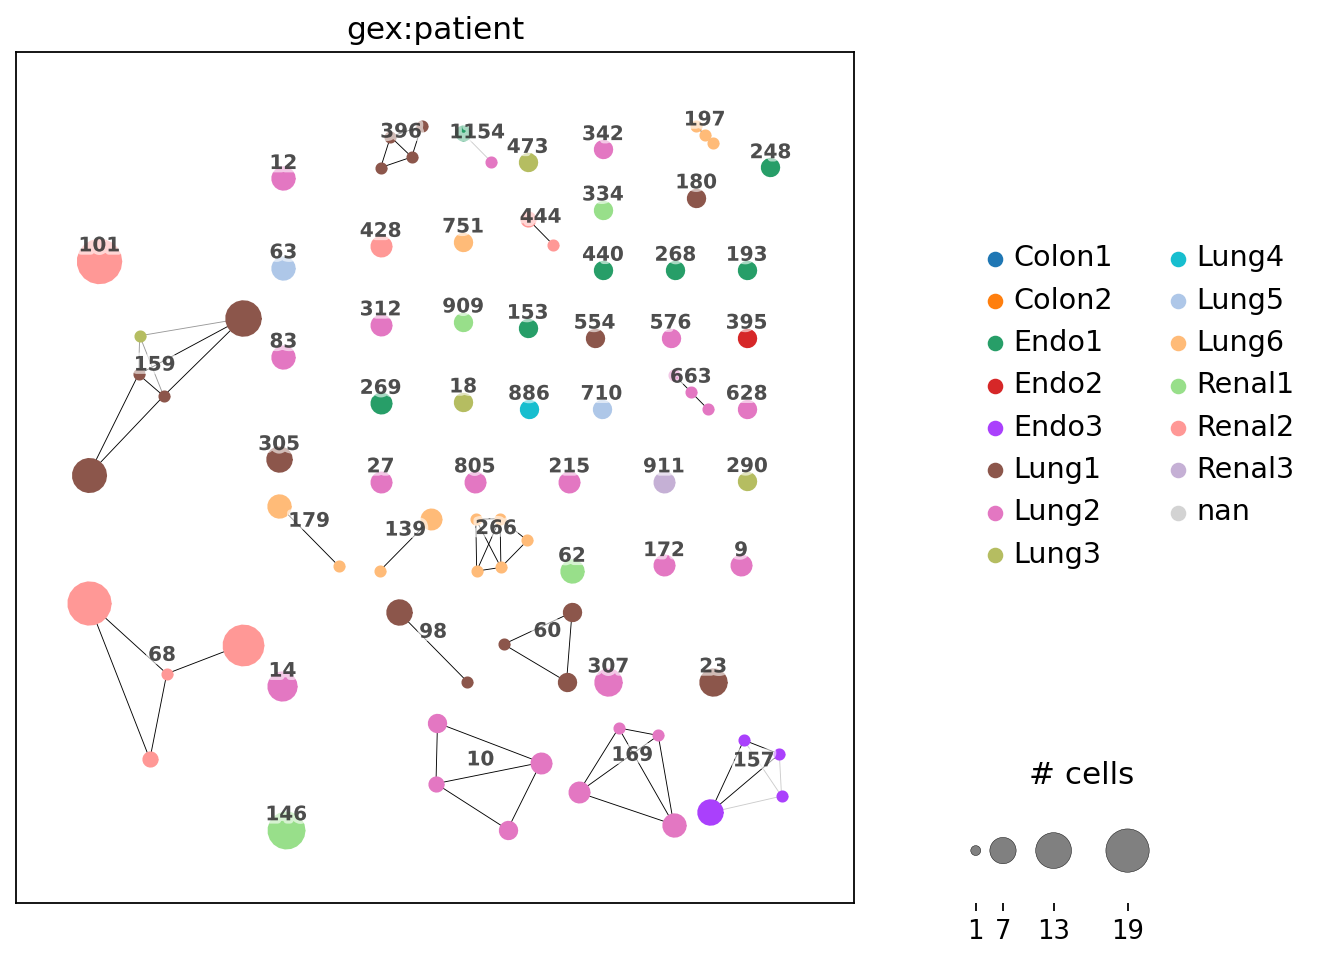

In [29]:
_ = ir.pl.clonotype_network(mdata, color="gex:patient", label_fontsize=9, panel_size=(7, 7), base_size=20)

:::{note}

Since v0.13, AIRR data is not by default included in `obs`. We can retrieve a per-cell data frame with AIRR information
using {func}`scirpy.get.airr`, or temporarily add columns to `obs` using the {func}`scirpy.get.airr_context` context
manager. For more information, see {ref}`accessing-airr-data`.
:::

We can now extract information (e.g. CDR3-sequences) from a specific clonotype cluster by subsetting `MuData`.
By extracting the CDR3 sequences of clonotype cluster `159`, we retreive five different receptor configurations with different numbers of cells, corresponding to the five points in the graph.

In [30]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    cdr3_ct_159 = (
        # TODO astype(str) is required due to a bug in pandas ignoring `dropna=False`. It seems fixed in pandas 2.x
        mdata.obs.loc[lambda x: x["airr:cc_aa_tcrdist"] == "159"]
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
cdr3_ct_159

VJ_1_junction_aa VDJ_1_junction_aa VJ_2_junction_aa VDJ_2_junction_aa  \
0    CAGKAGNTGKLIF     CASSYQGSTEAFF              nan               nan   
1    CAGKSGNTGKLIF     CASSYQGATEAFF  CATDPRRSTGNQFYF               nan   
2    CAGKSGNTGKLIF     CASSYQGATEAFF              nan               nan   
3  CATDPRRSTGNQFYF     CASSYQGATEAFF    CAGKSGNTGKLIF               nan   
4  CATDPRRSTGNQFYF     CASSYQGATEAFF              nan               nan   

  airr:receptor_subtype  n_cells  
0               TRA+TRB        1  
1               TRA+TRB        1  
2               TRA+TRB       12  
3               TRA+TRB        1  
4               TRA+TRB       11

### Including the V-gene in clonotype definition


Using the paramter `use_v_gene` in {func}`~scirpy.tl.define_clonotypes`, we can enforce
clonotypes (or clonotype clusters) to have the same {term}`V-gene <V(D)J>`, and, therefore, the same {term}`CDR1 and 2 <CDR>`
regions. Let's look for clonotype clusters with different V genes:


In [31]:
ir.tl.define_clonotype_clusters(
    mdata,
    sequence="aa",
    metric="tcrdist",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    key_added="cc_aa_tcrdist_same_v",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:cc_aa_tcrdist_same_v"]`.
Stored result in `mdata.obs["airr:cc_aa_tcrdist_same_v_size"]`.


In [32]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = mdata.obs.groupby("airr:cc_aa_tcrdist").apply(lambda x: x["airr:cc_aa_tcrdist_same_v"].nunique() > 1)
ct_different_v = ct_different_v[ct_different_v].index.values.tolist()
ct_different_v

['766']

Here, we see that the clonotype clusters `280` and `765` get split into `(280, 788)` and `(765, 1071)`, respectively, when the `same_v_gene` flag is set.

In [33]:
with ir.get.airr_context(mdata, "v_call", ["VJ_1", "VDJ_1"]):
    ct_different_v_df = (
        mdata.obs.loc[
            lambda x: x["airr:cc_aa_tcrdist"].isin(ct_different_v),
            [
                "airr:cc_aa_tcrdist",
                "airr:cc_aa_tcrdist_same_v",
                "VJ_1_v_call",
                "VDJ_1_v_call",
            ],
        ]
        .sort_values("airr:cc_aa_tcrdist")
        .drop_duplicates()
        .reset_index(drop=True)
    )
ct_different_v_df

airr:cc_aa_tcrdist airr:cc_aa_tcrdist_same_v VJ_1_v_call VDJ_1_v_call
0                766                       766      TRAV21      TRBV6-6
1                766                      1072      TRAV21      TRBV6-5

## Clonotype analysis

### Clonal expansion


Let's visualize the number of expanded clonotypes (i.e. clonotypes consisting
of more than one cell) by cell-type. The first option is to add a column with the {func}`scirpy.tl.clonal_expansion`
to `adata.obs` and overlay it on the UMAP plot.


In [34]:
ir.tl.clonal_expansion(mdata)

Stored result in `mdata.obs["airr:clonal_expansion"]`.


`clonal_expansion` refers to expansion categories, i.e singleton clonotypes, clonotypes with 2 cells and more than 2 cells.
The `clonotype_size` refers to the absolute number of cells in a clonotype.

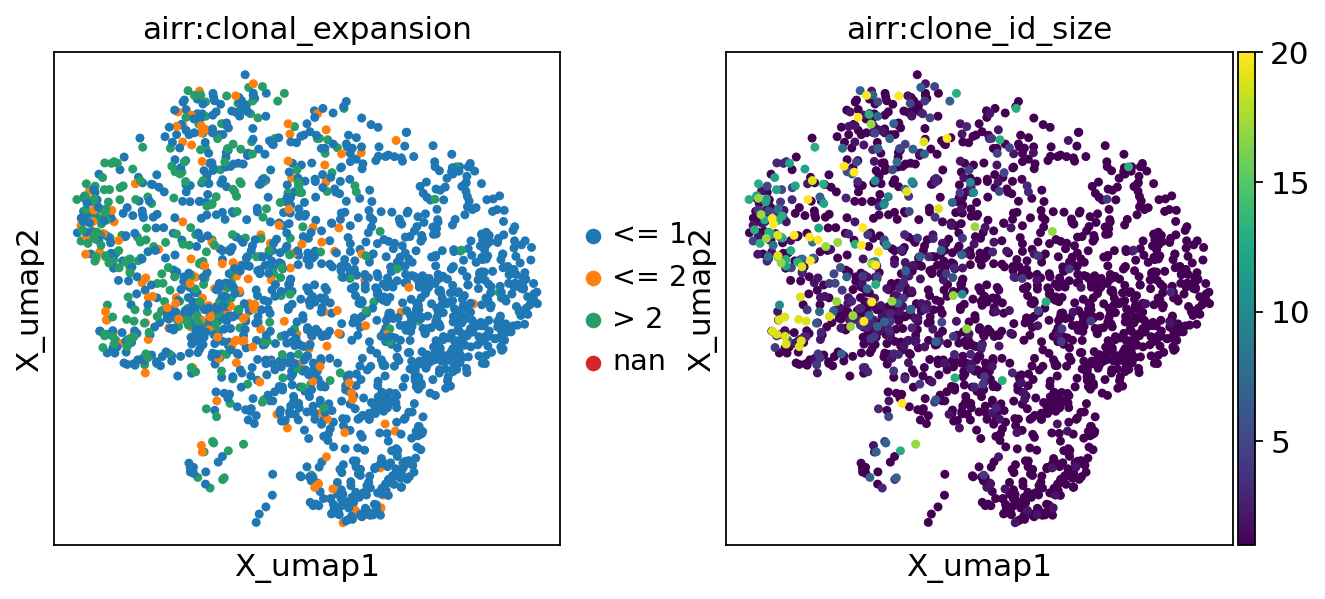

In [35]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"])


The second option is to show the number of cells belonging to an expanded clonotype per category
in a stacked bar plot, using the {func}`scirpy.pl.clonal_expansion` plotting function.


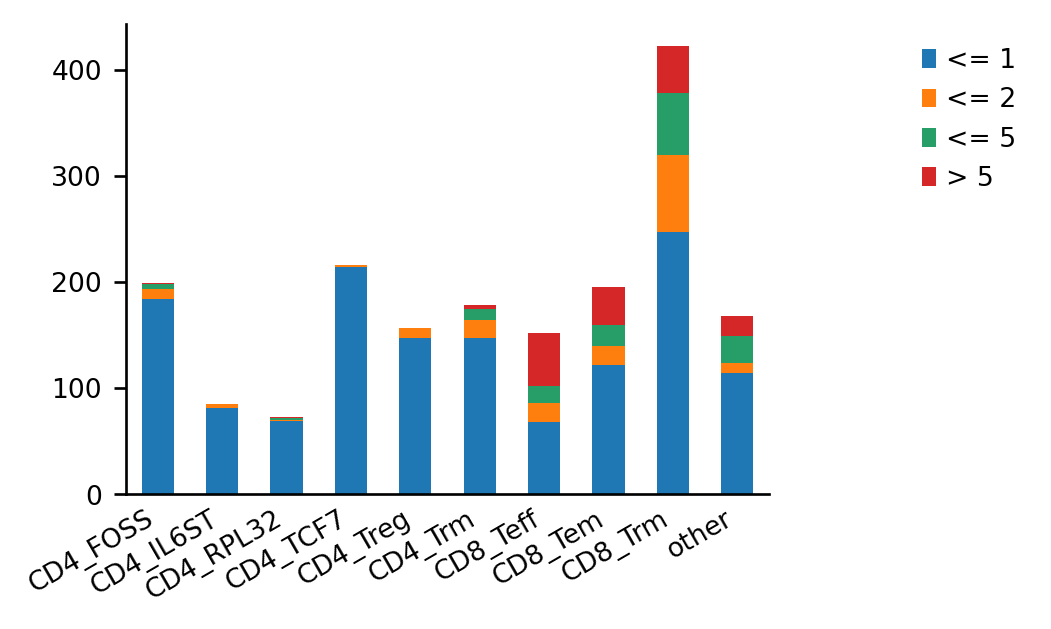

In [36]:
_ = ir.pl.clonal_expansion(mdata, target_col="clone_id", groupby="gex:cluster", breakpoints=(1, 2, 5), normalize=False)

The same plot, normalized to cluster size. Clonal expansion is a sign of positive selection
for a certain, reactive T-cell clone. It, therefore, makes sense that CD8+ effector T-cells
have the largest fraction of expanded clonotypes.

<Axes: >

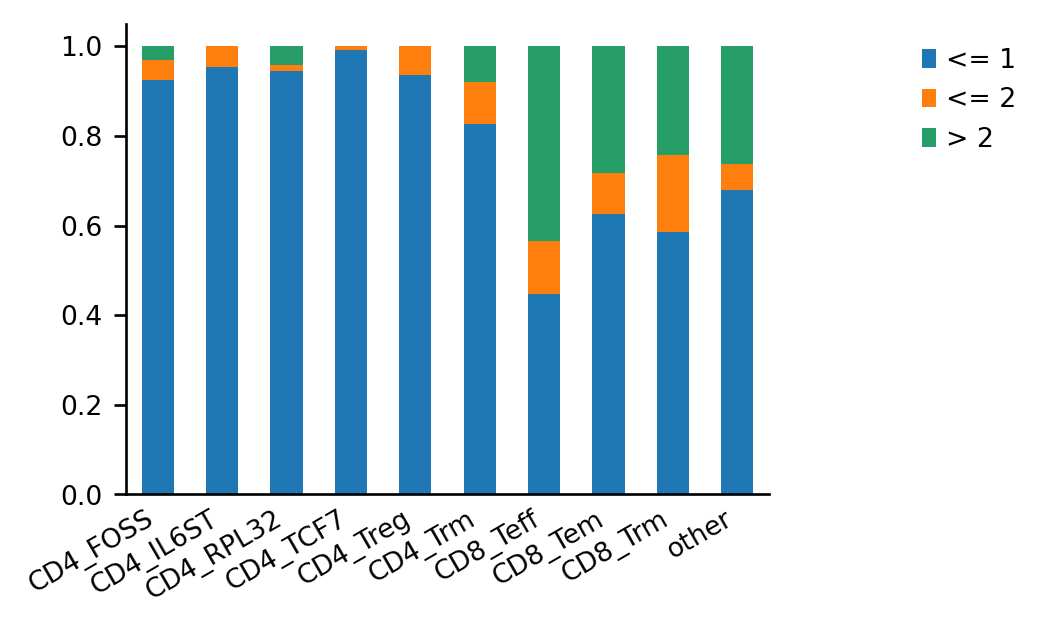

In [37]:
ir.pl.clonal_expansion(mdata, target_col="clone_id", groupby="gex:cluster")


Expectedly, the CD8+ effector T cells have the largest fraction of expanded clonotypes.

Consistent with this observation, they have the lowest {func}`scirpy.pl.alpha_diversity` of clonotypes.


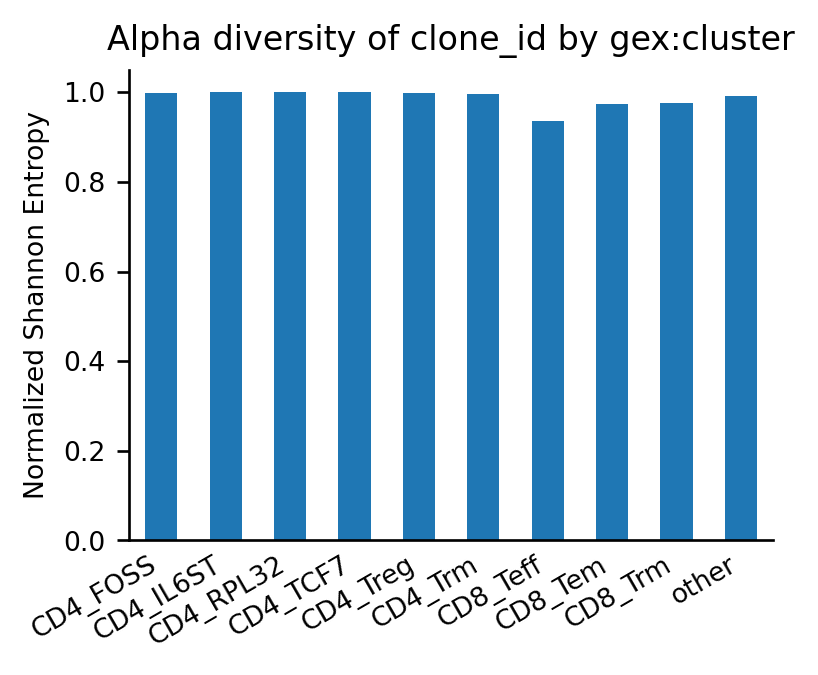

In [38]:
_ = ir.pl.alpha_diversity(mdata, metric="normalized_shannon_entropy", groupby="gex:cluster")

### Clonotype abundance


The function {func}`scirpy.pl.group_abundance` allows us to create bar charts for
arbitrary categorial from `obs`. Here, we use it to show the distribution of them
ten largest clonotypes across the cell-type clusters.


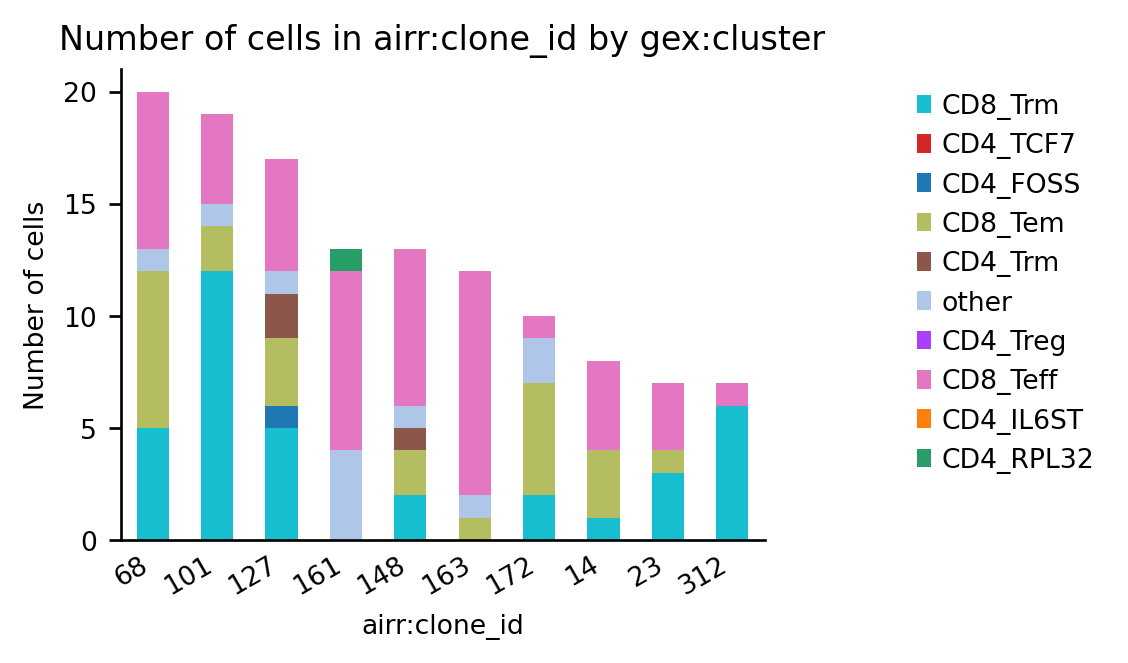

In [39]:
_ = ir.pl.group_abundance(mdata, groupby="airr:clone_id", target_col="gex:cluster", max_cols=10)

It might be beneficial to normalize the counts
to the number of cells per sample to mitigate biases due to different sample sizes:

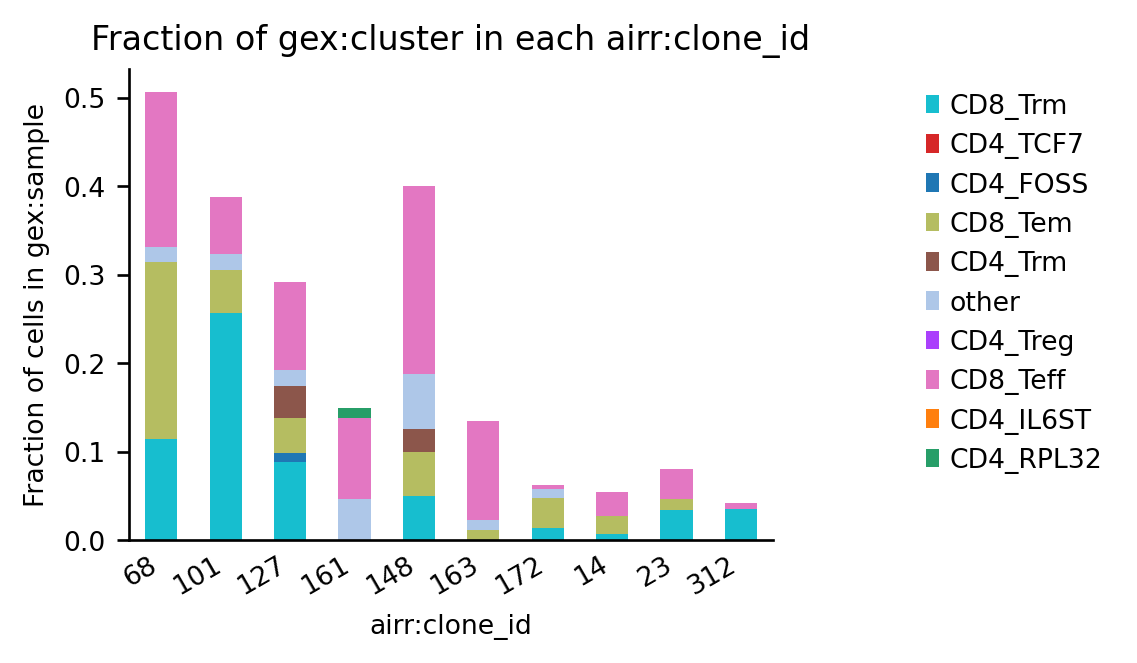

In [40]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:cluster",
    max_cols=10,
    normalize="gex:sample",
)

Coloring the bars by patient gives us information about public and private clonotypes:
Some clonotypes are _private_, i.e. specific to a certain tissue,
others are _public_, i.e. they are shared across different tissues.

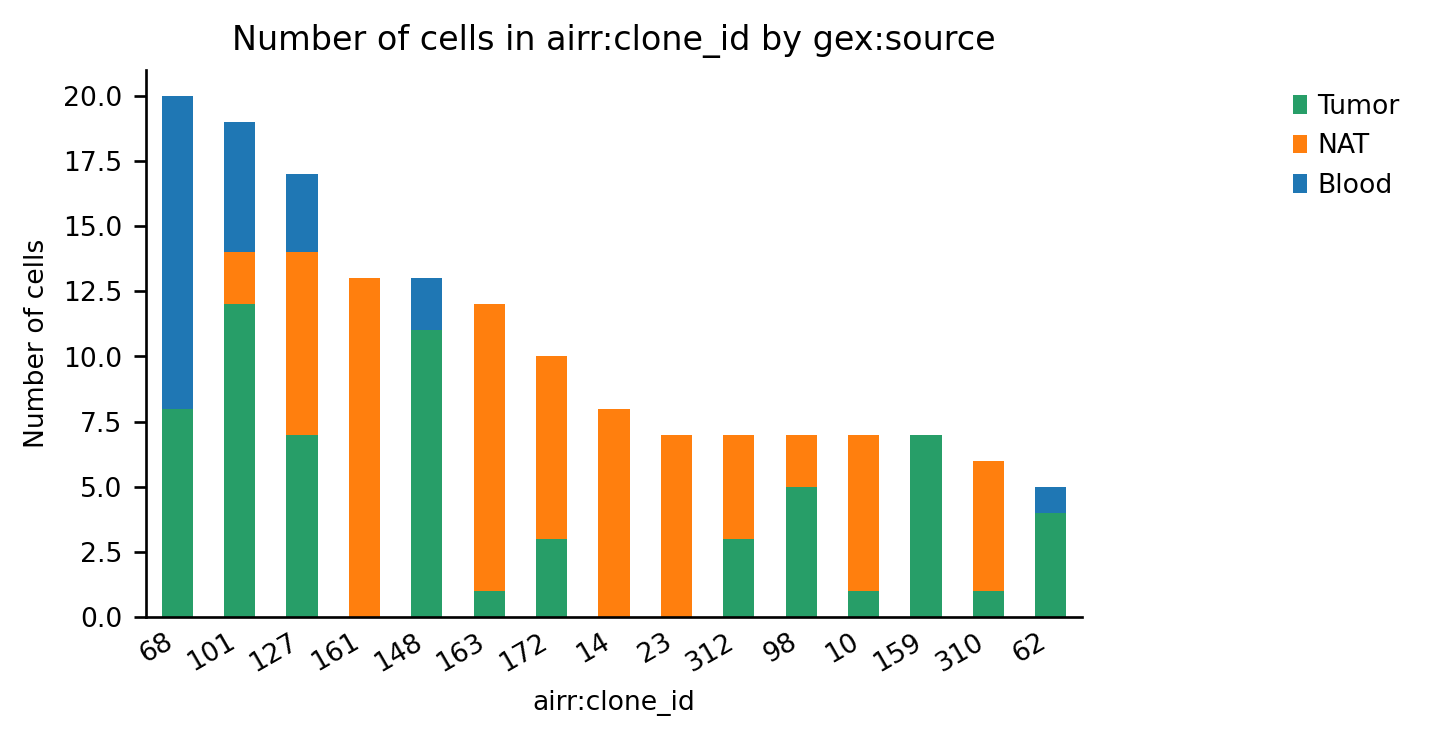

In [41]:
_ = ir.pl.group_abundance(mdata, groupby="airr:clone_id", target_col="gex:source", max_cols=15, figsize=(5, 3))

However, clonotypes that are shared between _patients_ are rare:

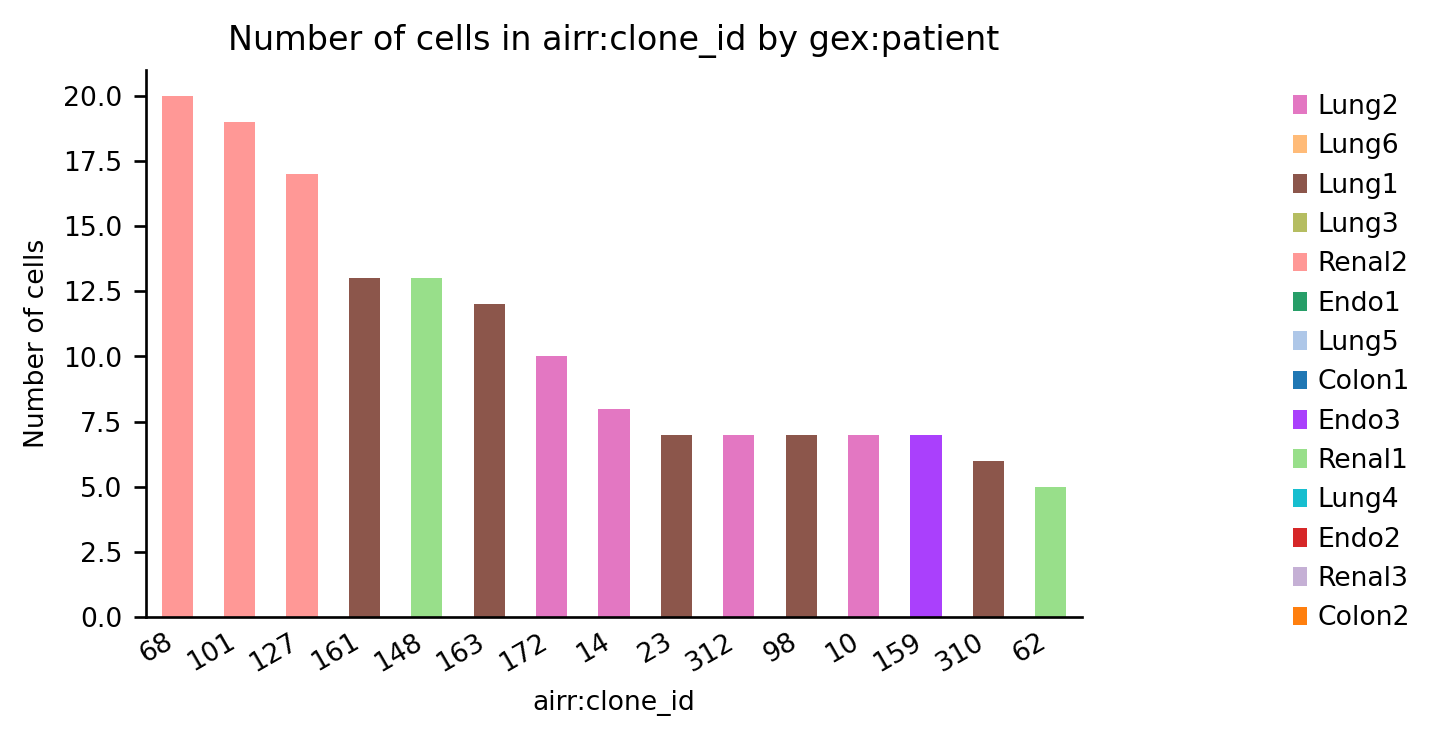

In [42]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:patient",
    max_cols=15,
    figsize=(5, 3),
)

### Convergent evolution


By comparing two levels of clonotype definitions (e.g. based on nucleotide sequences and based on amino-acid sequences),
we can identify receptors that are subject to {term}`convergent evolution <Convergent evolution of clonotypes>`. By that,
we mean receptors that (likely) recognize the same antigen but have evolved from different clones.


In [43]:
ir.tl.clonotype_convergence(mdata, key_coarse="cc_aa_tcrdist", key_fine="clone_id")

Stored result in `mdata.obs["airr:is_convergent"]`.


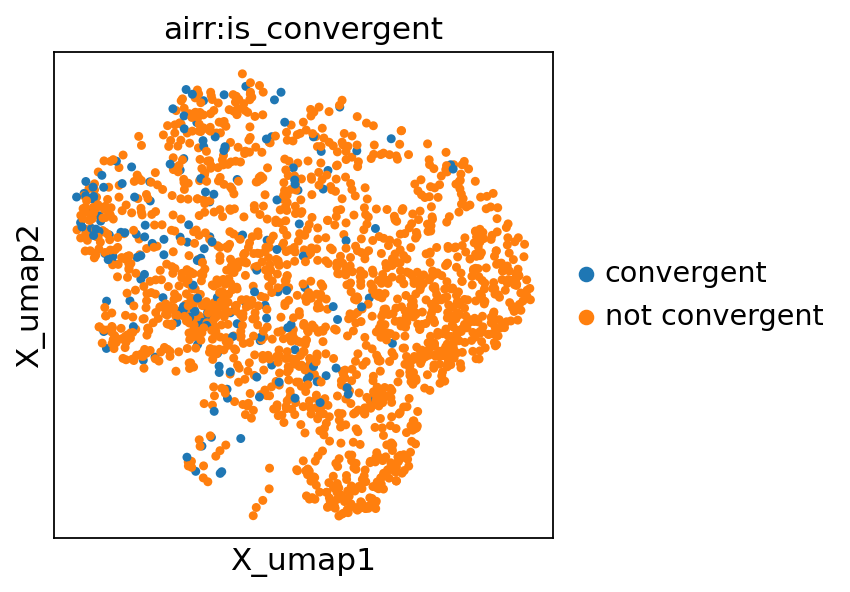

In [44]:
mu.pl.embedding(mdata, "gex:umap", color="airr:is_convergent")

## Motif analysis

A common tool to investiate the amino acid sequences of a group of receptors are Logoplots. We can use {func}`~scirpy.pl.logoplot_cdr3_motif` to generate a logoplot of a all CDR3 amino acid sequences in `mdata`. By subsetting `mdata`, we
can, for instance, plot the sequence motif of receptors of CD8+ effector cells. Note that sequence logos can only 
be generated of sequences of the same length. We therefore filter for sequences with length 14. You can inspect other
lengths the same way. 

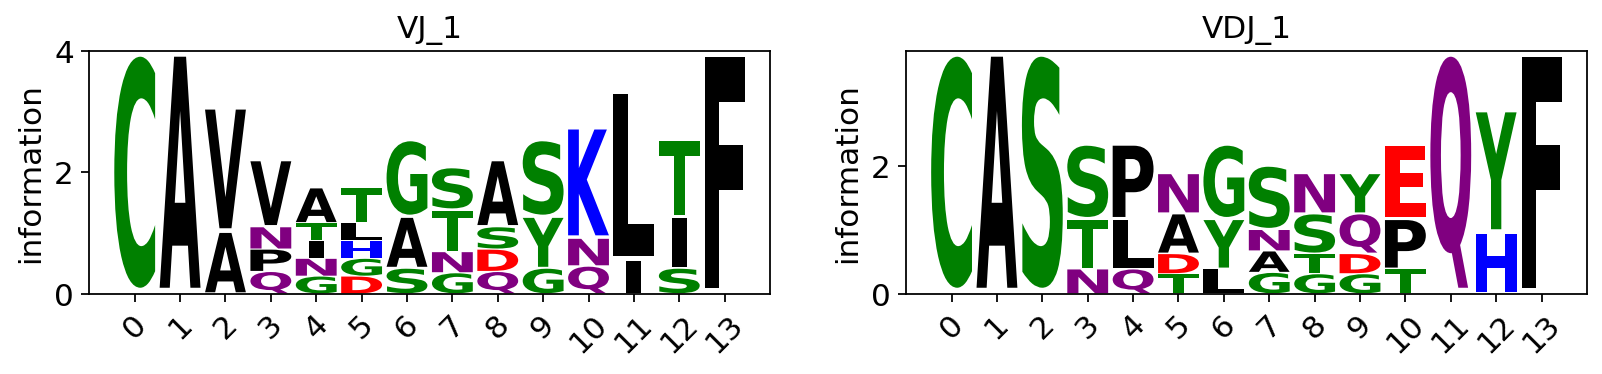

In [45]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata[
            (mdata.obs["gex:cluster"] == "CD8_Teff")
            & (ir.get.airr(mdata, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

## Gene usage


{func}`scirpy.tl.group_abundance` can also give us some information on VDJ usage.
We first add information about `v_call` to `obs` using {func}`~scirpy.get.airr_context` and then generate a bar plot by the `VJ_1_v_call` variable. 
We use `max_col` to limit the plot to the 10 most abundant V-genes.


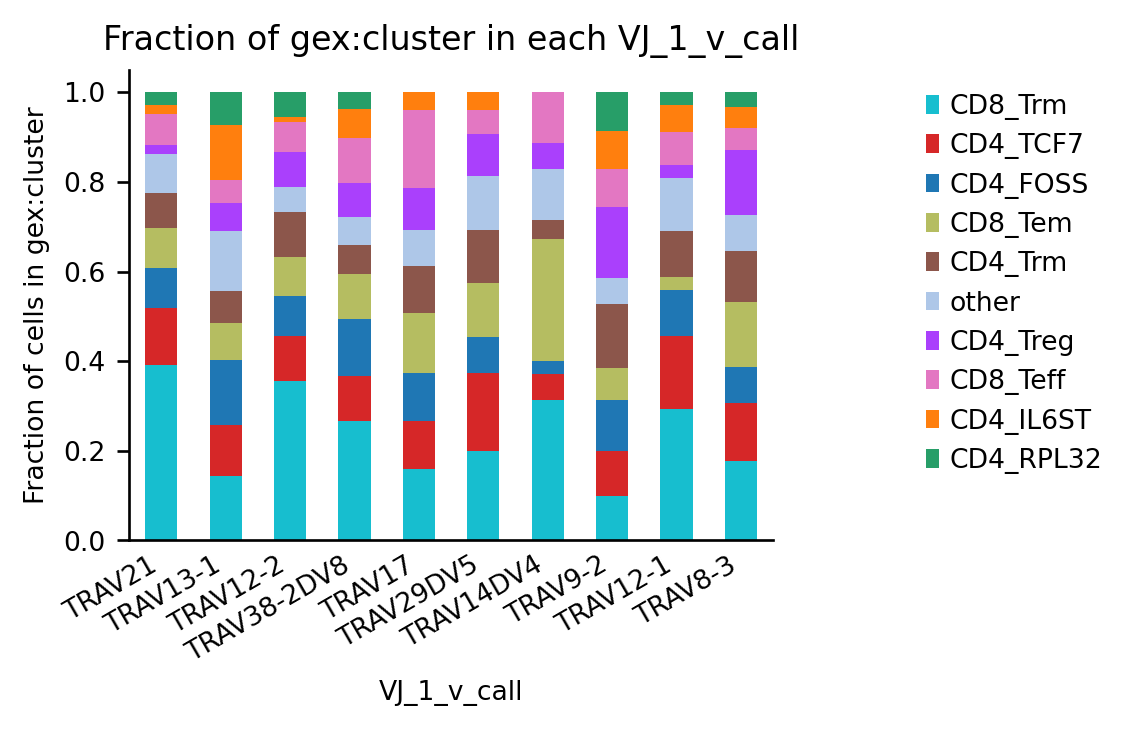

In [46]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:cluster",
        normalize=True,
        max_cols=10,
    )

We can pre-select groups by filtering `adata`:

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


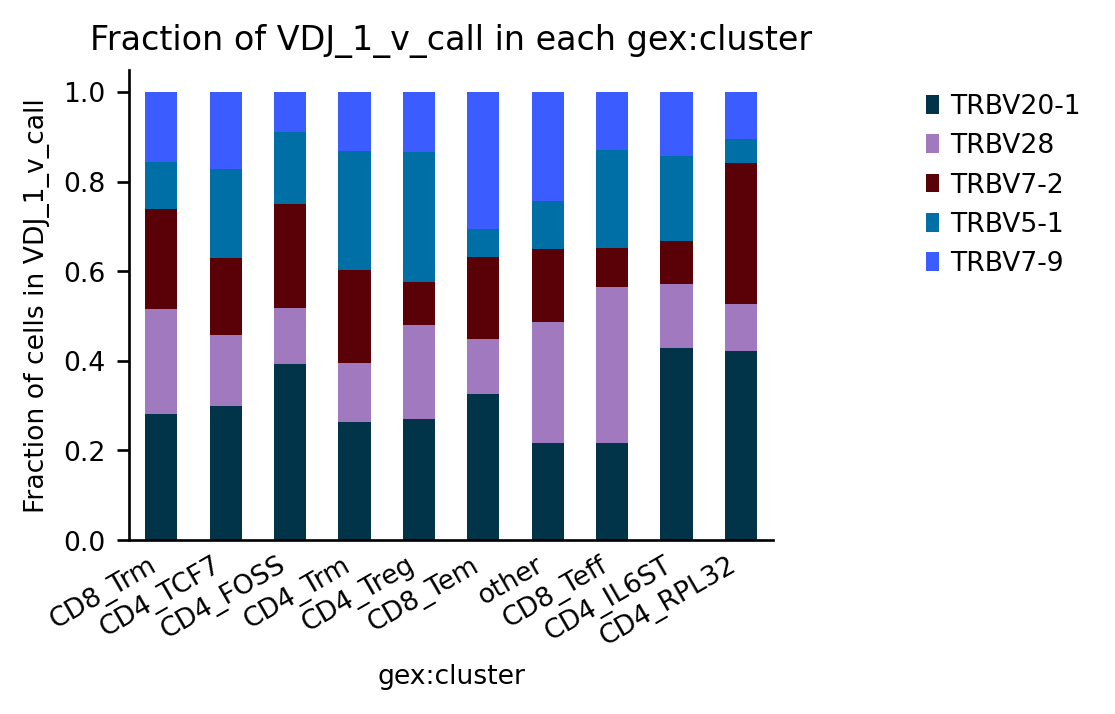

In [47]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata[
            mdata.obs["VDJ_1_v_call"].isin(["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]),
            :,
        ],
        groupby="gex:cluster",
        target_col="VDJ_1_v_call",
        normalize=True,
    )


The exact combinations of VDJ genes can be visualized as a Sankey-plot using {func}`scirpy.pl.vdj_usage`.


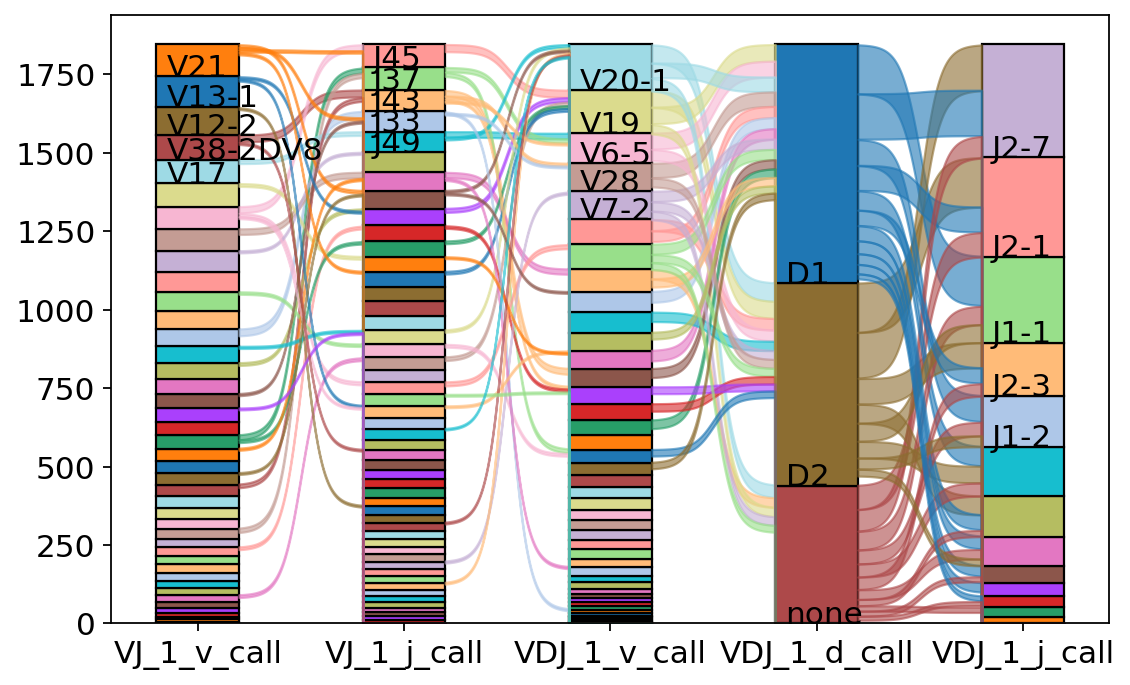

In [48]:
_ = ir.pl.vdj_usage(
    mdata,
    full_combination=False,
    max_segments=None,
    max_ribbons=30,
    fig_kws={"figsize": (8, 5)},
)

We can also use this plot to investigate the exact VDJ composition of one (or several) clonotypes:

<Axes: >

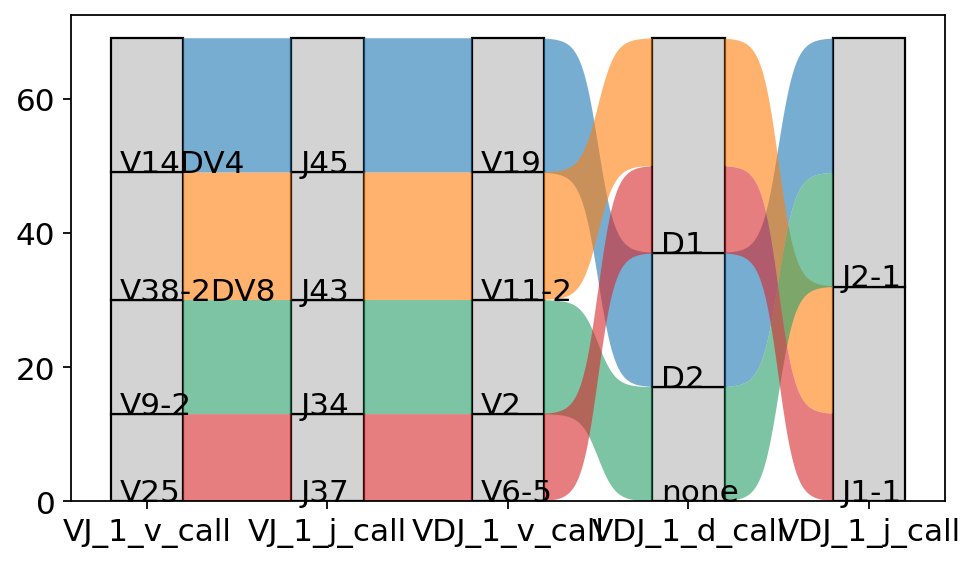

In [49]:
ir.pl.vdj_usage(
    mdata[mdata.obs["airr:clone_id"].isin(["68", "101", "127", "161"]), :],
    max_ribbons=None,
    max_segments=100,
)

### Spectratype plots


{func}`~scirpy.pl.spectratype` plots give us information about the length distribution of CDR3 regions.


<Axes: title={'center': 'Spectratype of junction_aa by gex:cluster'}, xlabel='junction_aa length', ylabel='Number of cells'>

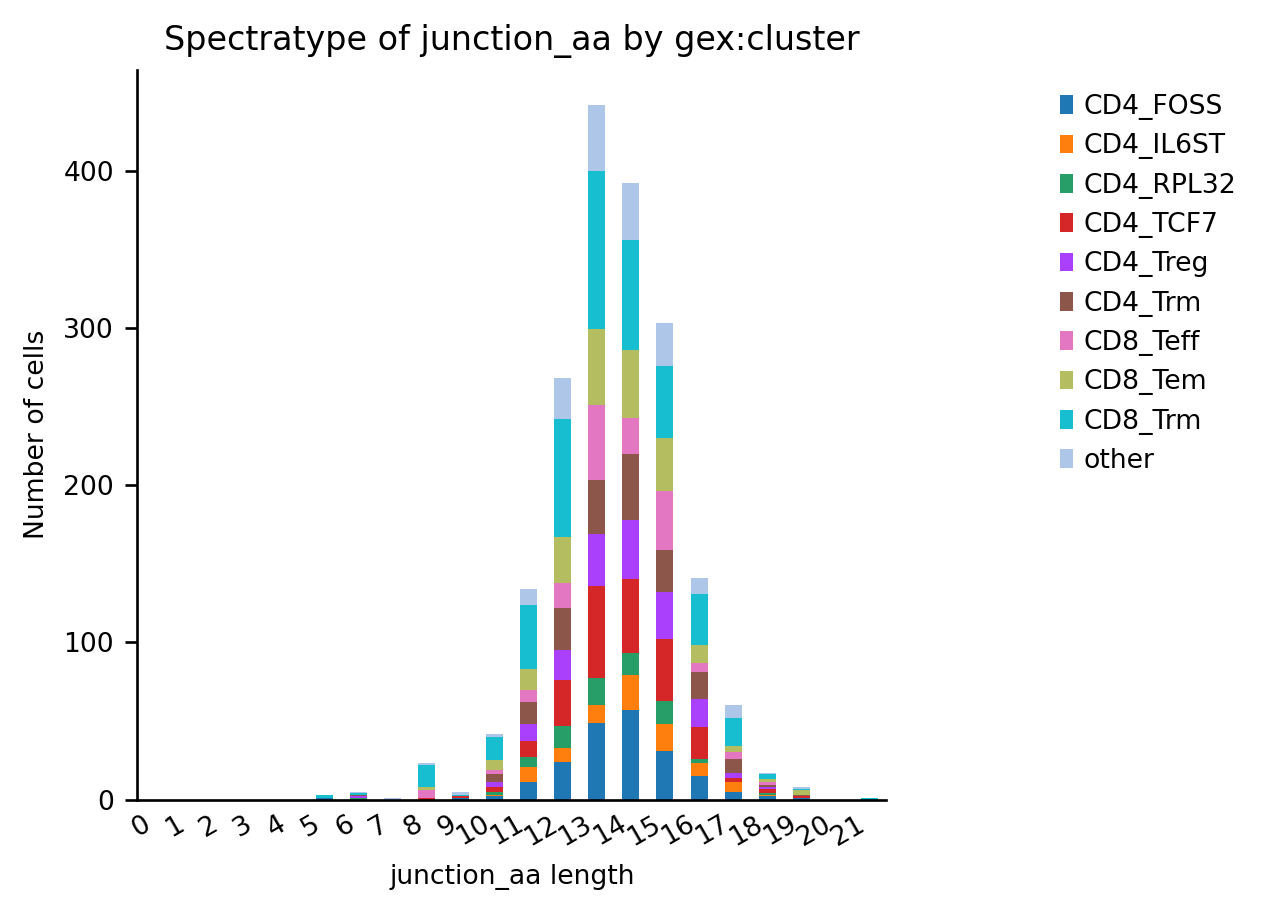

In [50]:
ir.pl.spectratype(mdata, color="gex:cluster", viztype="bar", fig_kws={"dpi": 120})

The same chart visualized as "ridge"-plot:

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scirpy/pl/base.py:262: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(order)


<Axes: title={'center': 'Spectratype of junction_aa by gex:cluster'}, xlabel='junction_aa length'>

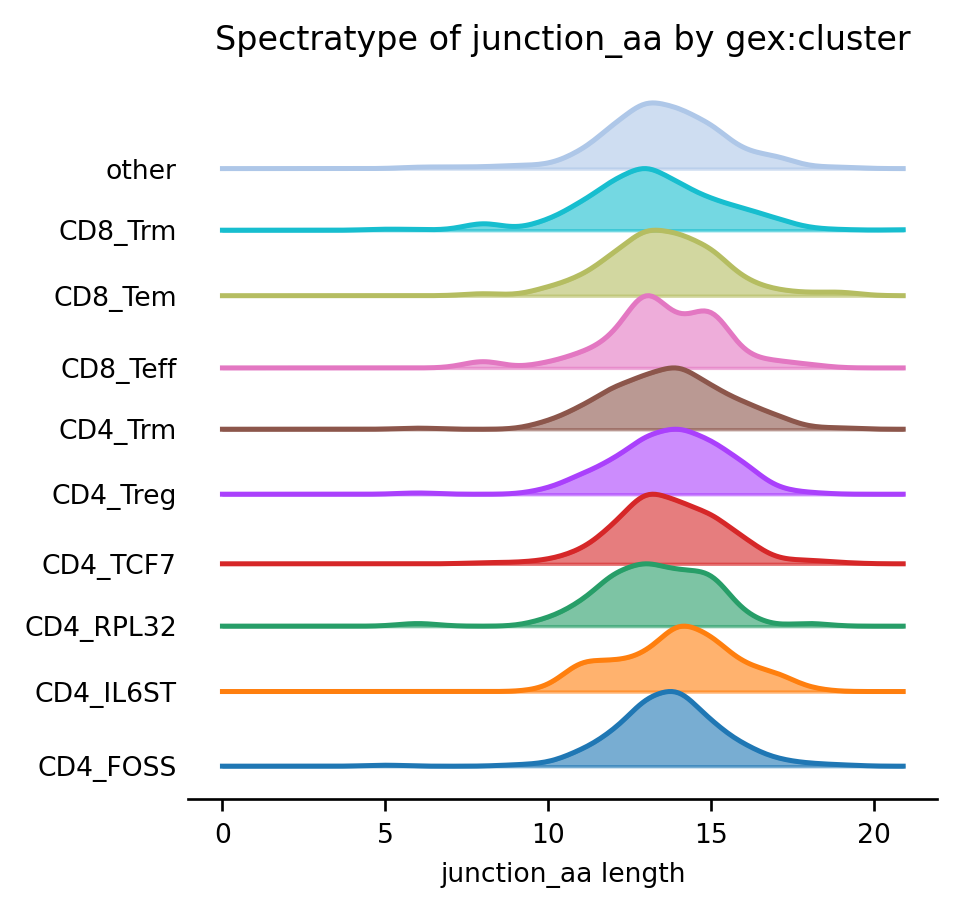

In [51]:
ir.pl.spectratype(
    mdata,
    color="gex:cluster",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": False},
)

A spectratype-plot by gene usage. To pre-select specific genes, we can simply filter the `mdata` object before plotting.

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


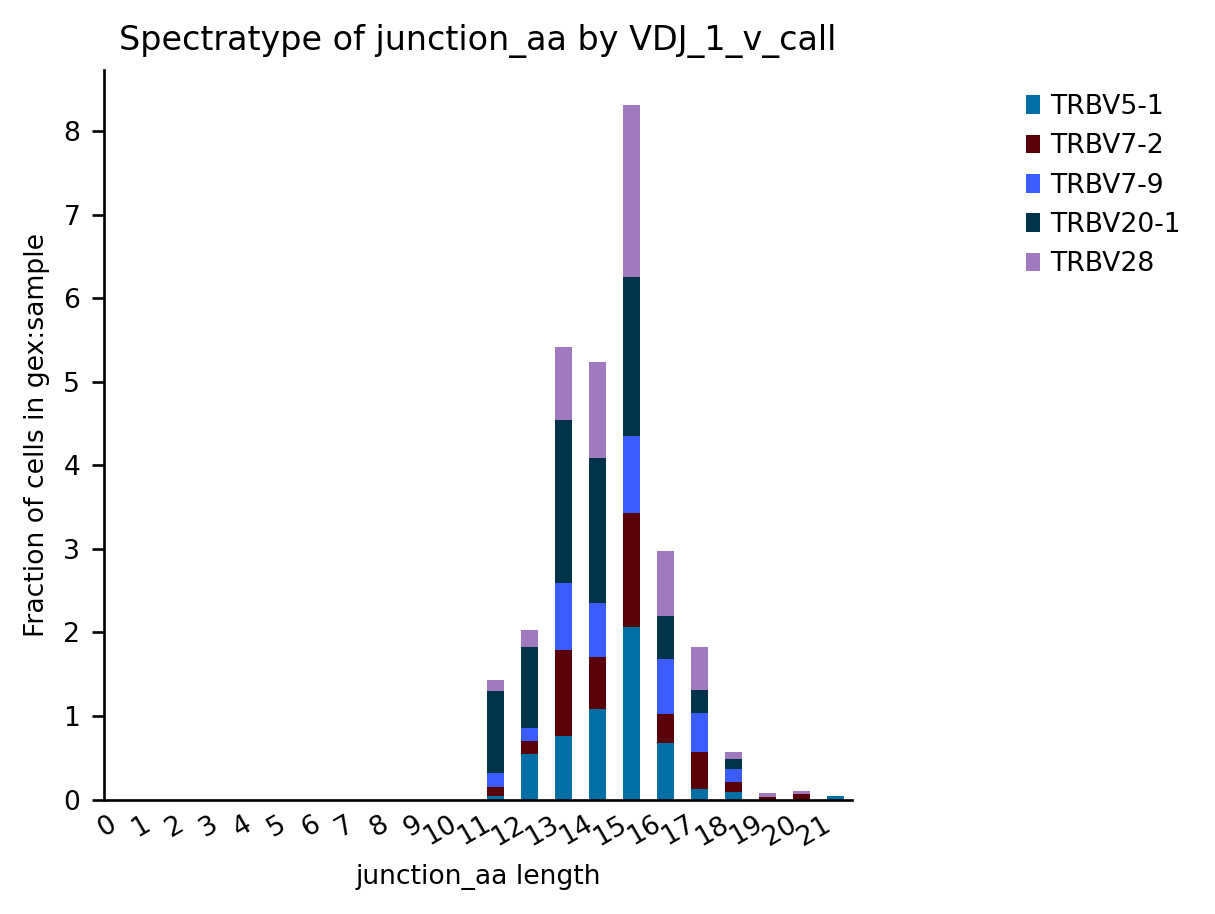

In [52]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.spectratype(
        mdata[
            mdata.obs["VDJ_1_v_call"].isin(["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]),
            :,
        ],
        chain="VDJ_1",
        color="VDJ_1_v_call",
        normalize="gex:sample",
        fig_kws={"dpi": 120},
    )

## Comparing repertoires

### Repertoire simlarity and overlaps


Overlaps in the adaptive immune receptor repertoire of samples or sample groups enables to pinpoint important clonotype groups, as well as to provide a measure of similarity between samples.
Running Scirpy's {func}`~scirpy.tl.repertoire_overlap` tool creates a matrix featuring the abundance of clonotypes in each sample. Additionally, it also computes a (Jaccard) distance matrix of samples as well as the linkage of hierarchical clustering.


In [53]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "gex:sample", inplace=False)
df.head()

clone_id      0    1    2    3    4    5    6    7    8    9  ...  1516  1517  \
gex:sample                                                    ...               
RN2         1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LN1         0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LN2         0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...   0.0   0.0   
LN4         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LT6         0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

clone_id    1518  1519  1520  1521  1522  1523  1524  1525  
gex:sample                                                  
RN2          0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
LN1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
LN2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
LN4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
LT6          1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  

[5 rows x 1526 columns]

The distance matrix can be shown as a heatmap, while samples are reordered based on hierarchical clustering.

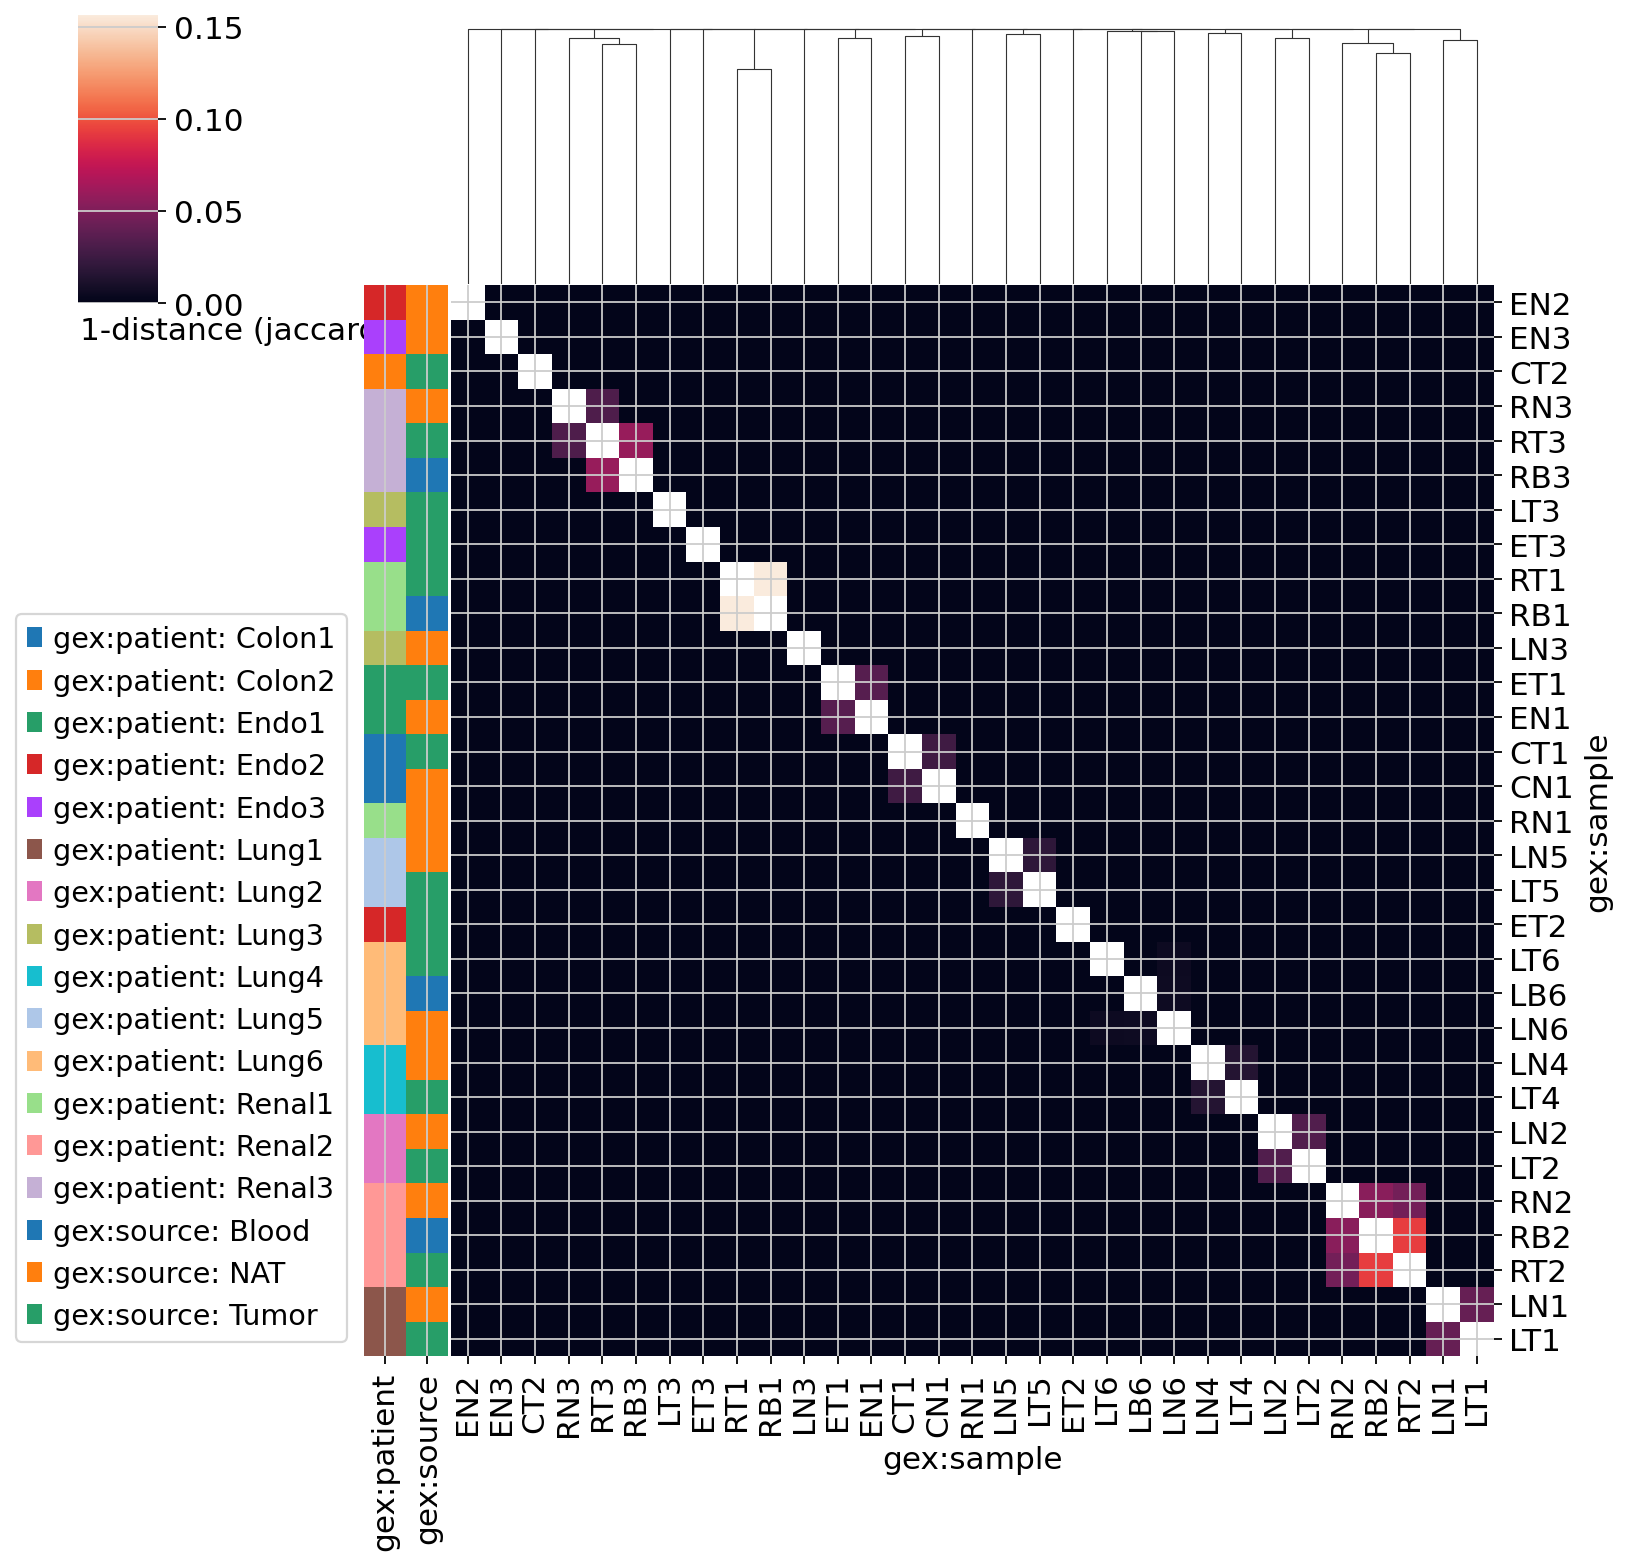

In [54]:
_ = ir.pl.repertoire_overlap(
    mdata,
    "gex:sample",
    heatmap_cats=["gex:patient", "gex:source"],
    yticklabels=True,
    xticklabels=True,
)

A specific pair of samples can be compared on a scatterplot, where dot size corresponds to the number of clonotypes at a given coordinate.

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scirpy/pl/styling.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


<Axes: title={'center': 'Repertoire overlap between LN2 and LT2'}, xlabel='Clonotype size in LN2', ylabel='Clonotype size in LT2'>

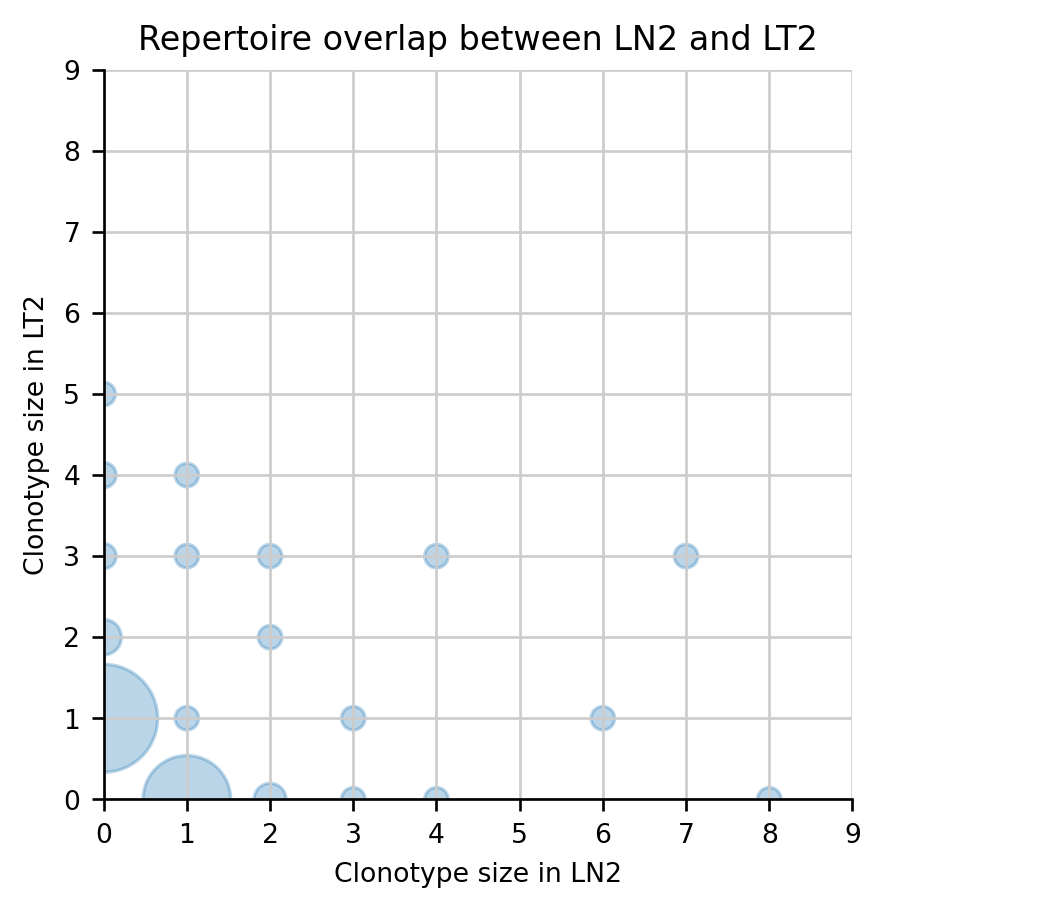

In [55]:
ir.pl.repertoire_overlap(mdata, "gex:sample", pair_to_plot=["LN2", "LT2"], fig_kws={"dpi": 120})

## Integrating gene expression data

Leveraging the opportunity offered by close integeration with scanpy, transcriptomics-based data can be utilized alongside immune receptor data.

### Clonotype modularity


Using the {term}`Clonotype modularity` we can identify clonotypes consisting of
cells that are transcriptionally more similar than expected by random.

The clonotype modularity score represents the log2 fold change of the
number of edges in the cell-cell neighborhood graph compared to
the random background model. Clonotypes (or clonotype clusters) with
a high modularity score consist of cells that have a similar molecular phenotype.


In [56]:
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_tcrdist")

Initalizing clonotype subgraphs...


100%|██████████| 1490/1490 [00:00<00:00, 48651.00it/s]

Computing background distributions...



100%|██████████| 1000/1000 [00:00<00:00, 1129.27it/s]


Stored result in `mdata.obs["airr:clonotype_modularity"]`.
Stored result in `mdata.obs["airr:clonotype_modularity_fdr"]`.


We can plot the clonotype modularity on top of a umap of clonotype network plot

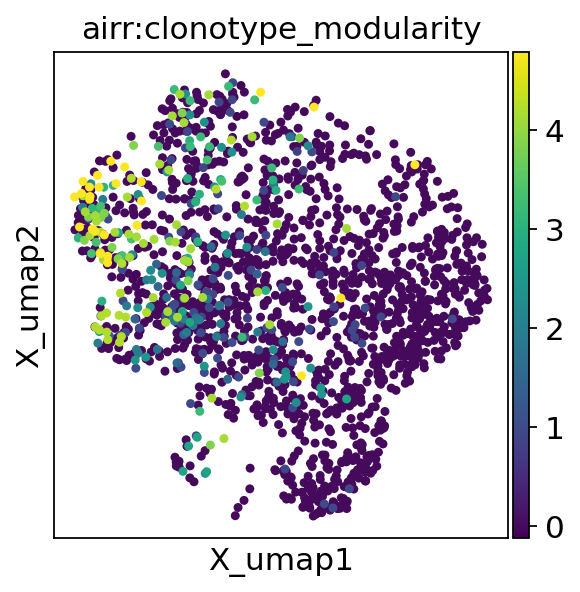

In [57]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:clonotype_modularity")

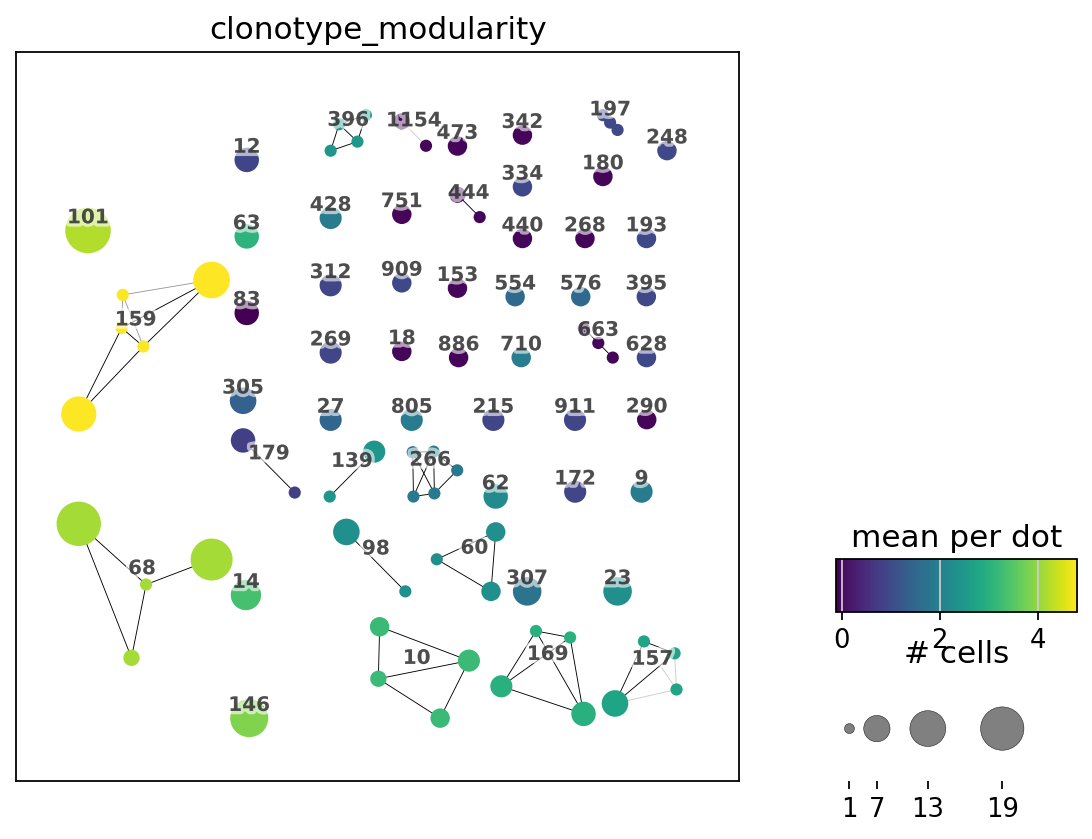

In [58]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)

We can also visualize the clonotype modularity together with the associated
FDR as a sort of "one sided volcano plot":

<Axes: xlabel='modularity score', ylabel='-log10(FDR)'>

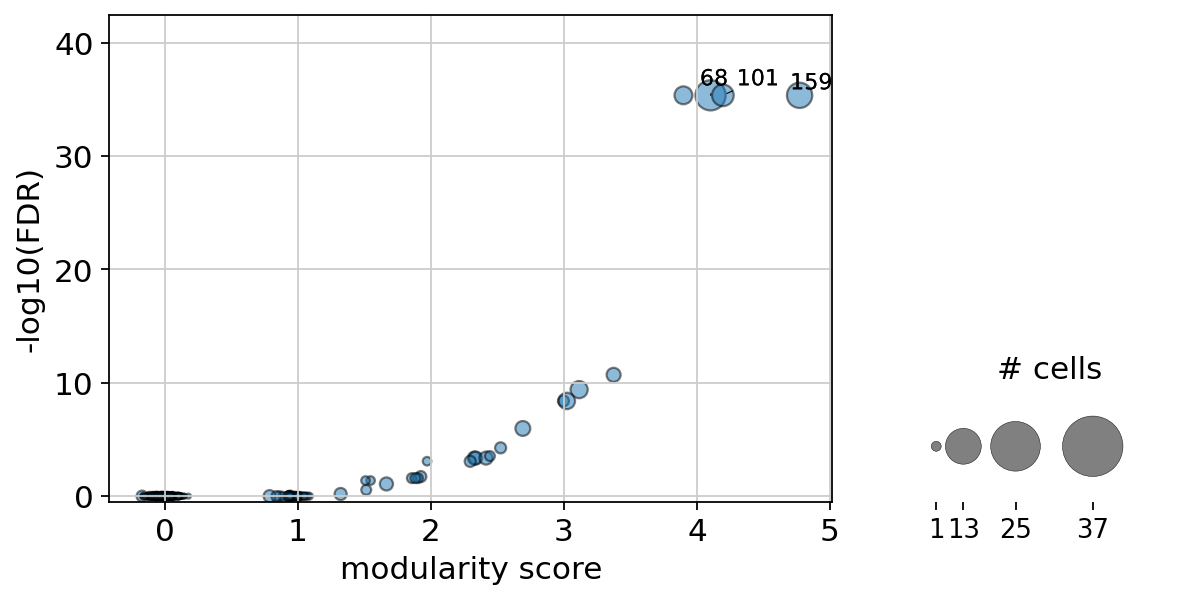

In [59]:
ir.pl.clonotype_modularity(mdata, base_size=20)

Let's further inspect the two top scoring candidates. We can extract that information from `mdata.obs["airr:clonotype_modularity"]`.

In [60]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_tcrdist")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:2]
)

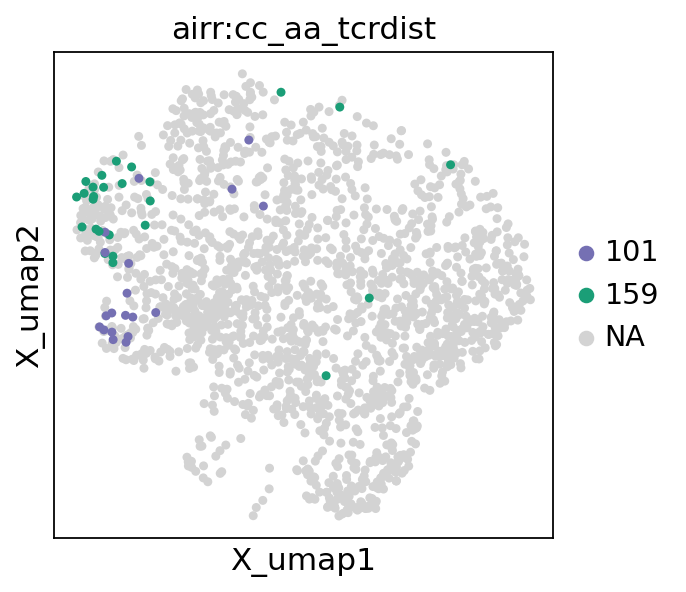

In [61]:
test_ad = mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:cc_aa_tcrdist",
    groups=clonotypes_top_modularity,
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

We observe that they are (mostly) restricted to a single cluster. By leveraging
scanpy's differential expression module, we can compare the gene expression
of the cells in the two clonotypes to the rest.

ranking genes
    finished (0:00:03)


/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")
/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


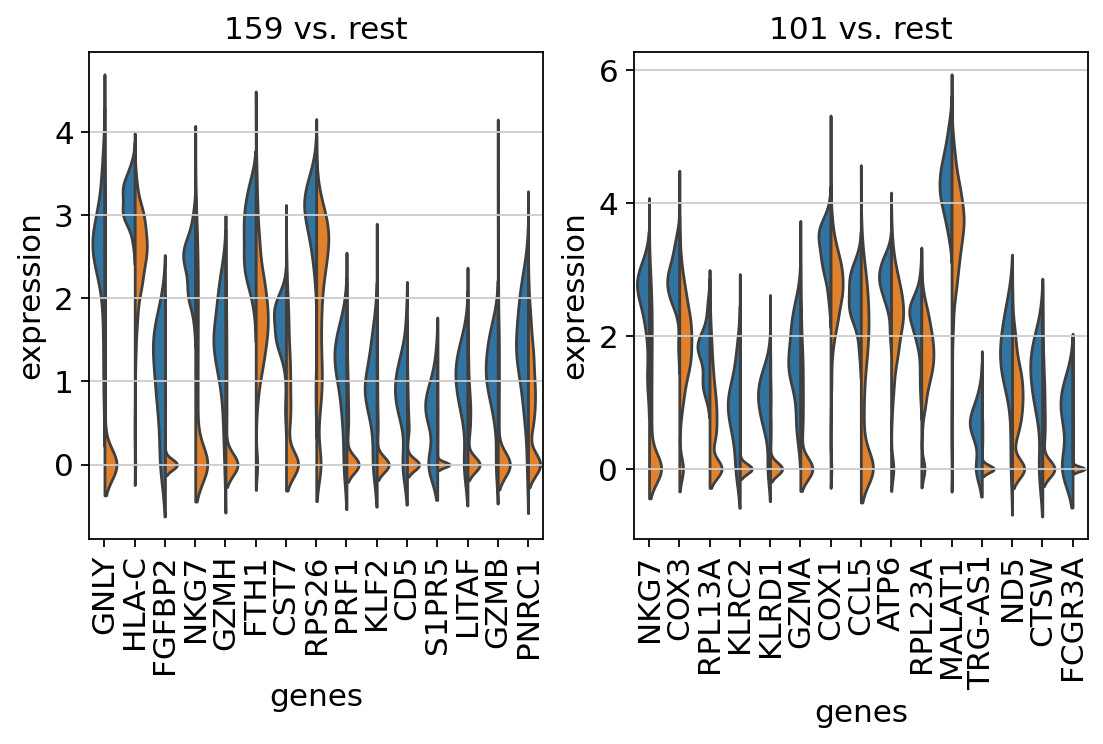

In [62]:
# Since sc.tl.rank_genes_group does not support MuData, we need to temporarily add
# the AIRR columns to the gene expression AnnData object
with ir.get.obs_context(mdata["gex"], {"cc_aa_tcrdist": mdata.obs["airr:cc_aa_tcrdist"]}) as tmp_ad:
    sc.tl.rank_genes_groups(
        tmp_ad,
        "cc_aa_tcrdist",
        groups=clonotypes_top_modularity,
        reference="rest",
        method="wilcoxon",
    )
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for ct, ax in zip(clonotypes_top_modularity, axs, strict=False):
        sc.pl.rank_genes_groups_violin(tmp_ad, groups=[ct], n_genes=15, ax=ax, show=False, strip=False)

### Clonotype imbalance among cell clusters

Using cell type annotation inferred from gene expression clusters, for example, clonotypes belonging to CD8+ effector T-cells and CD8+ tissue-resident memory T cells, can be compared.

In [63]:
freq, stat = ir.tl.clonotype_imbalance(
    mdata,
    replicate_col="gex:sample",
    groupby="gex:cluster",
    case_label="CD8_Teff",
    control_label="CD8_Trm",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:3]

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scirpy/tl/_clonotype_imbalance.py:272: RuntimeWarning: divide by zero encountered in log2
  logfoldchange = np.log2((case_mean_freq + global_minimum) / (control_mean_freq + global_minimum))
/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scirpy/tl/_clonotype_imbalance.py:272: RuntimeWarning: divide by zero encountered in scalar divide
  logfoldchange = np.log2((case_mean_freq + global_minimum) / (control_mean_freq + global_minimum))


Showing top clonotypes on a UMAP clearly shows that clonotype 101 is featured by CD8+ tissue-resident memory T cells, while clonotype 68 by CD8+ effector and effector memory cells.

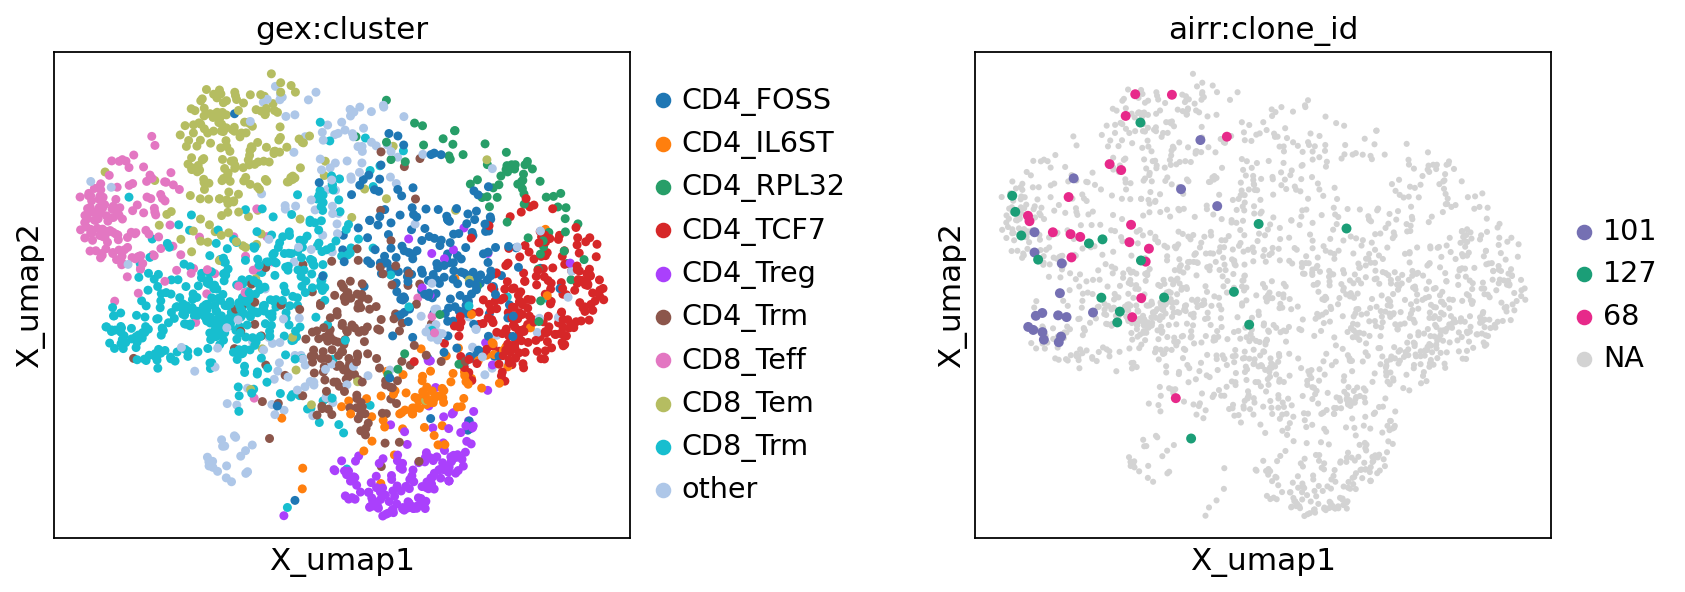

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
mu.pl.embedding(mdata, basis="gex:umap", color="gex:cluster", ax=ax1, show=False)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:clone_id",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30 for c in mdata.obs["airr:clone_id"][mdata.mod["gex"].obs_names]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

### Repertoire overlap of cell types

Just like comparing repertoire overlap among samples, Scirpy also offers comparison between gene expression clusters or cell subpopulations. As an example, repertoire overlap of the two cell types compared above is shown.

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scirpy/pl/styling.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


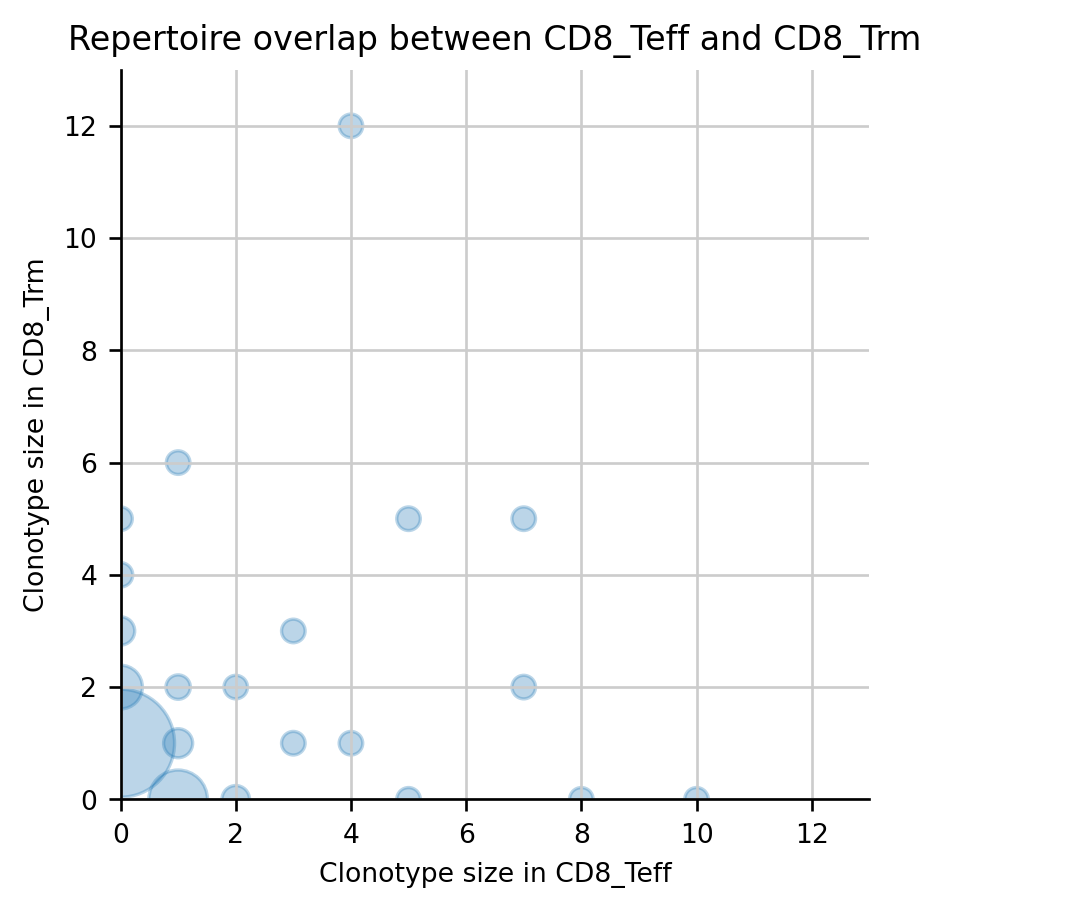

In [65]:
# ir.tl.repertoire_overlap(mdata, "gex:cluster")
_ = ir.pl.repertoire_overlap(mdata, "gex:cluster", pair_to_plot=["CD8_Teff", "CD8_Trm"], fig_kws={"dpi": 120})

### Marker genes in top clonotypes

Gene expression of cells belonging to individual clonotypes can also be compared using Scanpy. As an example, differential gene expression of two clonotypes, found to be specific to cell type clusters can also be analysed.

ranking genes
    finished (0:00:00)


/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


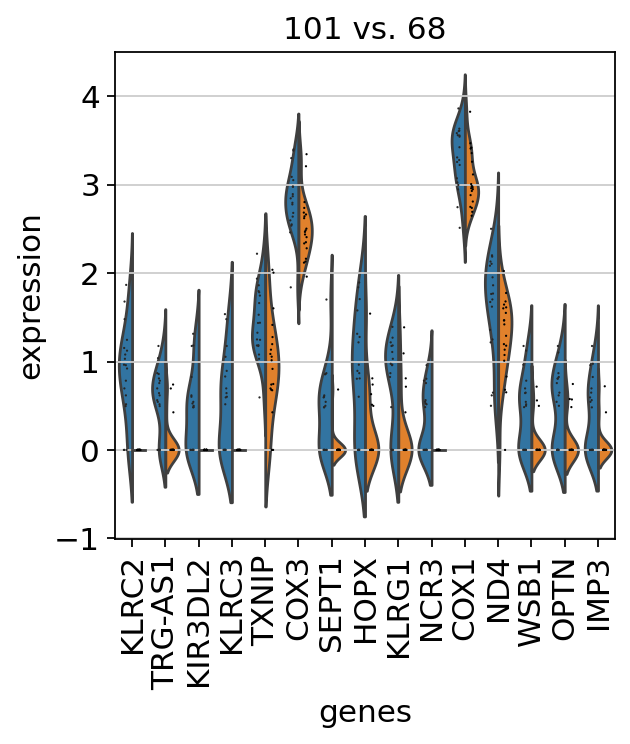

In [66]:
with ir.get.obs_context(mdata["gex"], {"clone_id": mdata.obs["airr:clone_id"]}) as tmp_ad:
    sc.tl.rank_genes_groups(tmp_ad, "clone_id", groups=["101"], reference="68", method="wilcoxon")
    sc.pl.rank_genes_groups_violin(tmp_ad, groups="101", n_genes=15)

## Query epitope databases


We can use scirpy to query reference databases or datasets to annotate {term}`IRs <IR>` with certain
features, such as epitope specificity. The reference database can be any dataset in {ref}`scirpy's AnnData format <data-structure>` and you can follow the instructions in the {ref}`data loading tutorial <importing-custom-formats>`
to build a custom reference database, if it is not available from {mod}`scirpy.datasets` yet.

Querying reference datasets uses the same logic as {ref}`defining clonotypes <define-clonotypes-tutorial>`:

```{eval-rst}
.. list-table:: Analysis steps on IR data
    :widths: 40 60
    :header-rows: 1

    - - scirpy function
      - objective
    - - :func:`scirpy.pp.ir_dist`
      - Compute sequence-based distance matrices .
    - - :func:`scirpy.tl.ir_query`
      - For each cell, identify matching entries in a reference database.
    - - :func:`scirpy.tl.ir_query_annotate`
      - Transfer annotations from reference database to `adata.obs`.
    - - :func:`scirpy.tl.ir_query_annotate_df`
      - Return a dataframe with all matching annotations.
```

Here, we obtain the {func}`VDJDB <scirpy.datasets.vdjdb>` and annotate epitopes based
on amino acid sequence identity. For demonstration purposes on this toy dataset we use rather lenient settings: For a match, we specify that it is enough that either of the {term}`VJ <V(D)J>` and {term}`VDJ <V(D)J>` sequences, and either of the primary or secondary receptor chains matches the database.


In [67]:
vdjdb = ir.datasets.vdjdb()

In [68]:
ir.io.upgrade_schema(vdjdb)

/home/frolova/micromamba/envs/scirpy_v0.22.3/lib/python3.10/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


In [69]:
ir.pp.ir_dist(mdata, vdjdb, metric="identity", sequence="aa")

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [70]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored IR distance matrix in `adata.uns["ir_query_VDJDB_aa_identity"]`.



{func}`~scirpy.tl.ir_query_annotate_df` allows us to retrieve *all pairs cells with their of matching entries*. If a cell matches multiple entires from the reference database, the resulting data frame will contain multiple rows for the same cell.


In [71]:
ir.tl.ir_query_annotate_df(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
).tail()

antigen.species antigen.gene
RT3_GCAGTTAGTATGAAAC-1             CMV          IE1
RT3_GCAGTTAGTATGAAAC-1             CMV          IE1
RT3_GCAGTTAGTATGAAAC-1             CMV          IE1
RT3_GCAGTTAGTATGAAAC-1             CMV          IE1
RT3_GCAGTTAGTATGAAAC-1      InfluenzaA           NP


Alternatively, to break down the annotation to a single-value per cell, you can use
{func}`~scirpy.tl.ir_query_annotate`. Depending on the specified `strategy` it will only label unambiguous matches, or use the most frequent value.


In [72]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species"],
    strategy="most-frequent",
)

100%|██████████| 342/342 [00:00<00:00, 5457.68it/s]

Stored result in `mdata.obs["airr:antigen.species"]`.


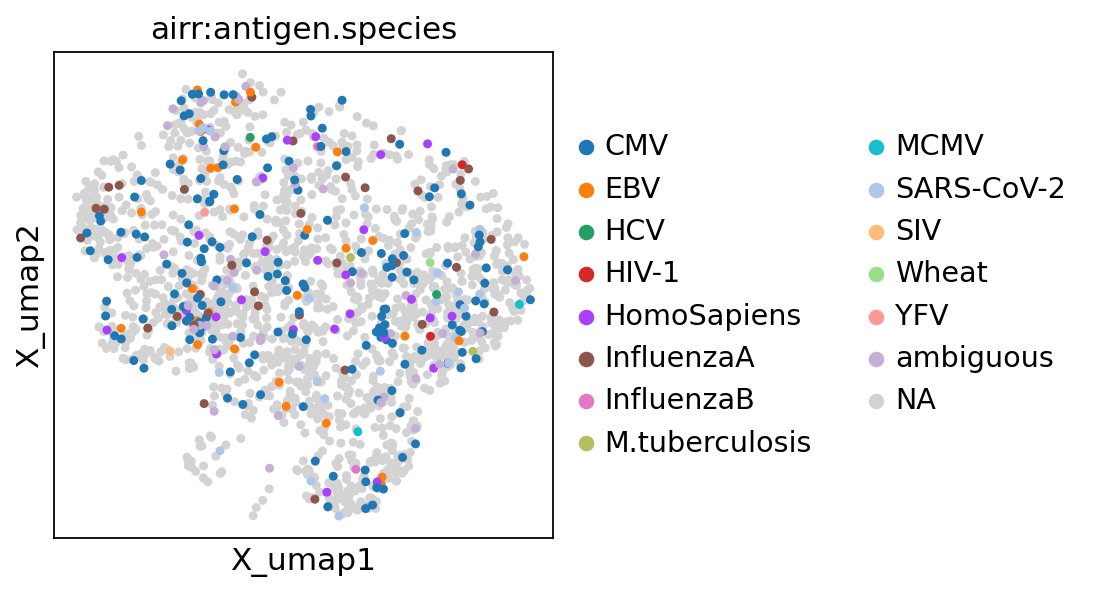

In [73]:
mu.pl.embedding(mdata, "gex:umap", color="airr:antigen.species")